This notebook can be understood as a continuation of C-RNN-GAN_vanilla.

Here we'll try out how well do different possibilities of architectures of the C-RNN-GAN with curriculum learning perfom.

Therefore, the architectures to be tested are:
- Simple architecture (2 layers deep both)
- Deeper simple architecture (3 layers deep both)
- Complex generator (2 layers deep both)
- Complex generator (3 layers deep discriminator)
- Complex generator (3 layers deep both)
- Complex discriminator (2 layers deep both)
- Complex discriminator (3 layers deep generator)
- Complex discriminator (3 layers deep both)
- Both complex (2 layers deep both)
- Both complex (3 layers deep discrminator)
- Both complex (3 layers deep generator)
- Both complex (3 layers deep both)

In [11]:
# Connect to google drive where we store out scripts and our generated songs.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Setup steps needed to be able to use music_data_utils. Basically, installing from source python3-midi, which music_data_utils uses. In order to install python3-midi a module called swig is needed and therefore we install it using the usual linux installer (apt-get).

Finally, to load the music_data_utils script and all the functionalities related to out implementation of C-RNN_GAN, we use the standard python importer.

In [2]:
!git clone https://github.com/louisabraham/python3-midi.git

Cloning into 'python3-midi'...
remote: Enumerating objects: 553, done.
remote: Total 553 (delta 0), reused 0 (delta 0), pack-reused 553
Receiving objects: 100% (553/553), 208.19 KiB | 382.00 KiB/s, done.
Resolving deltas: 100% (314/314), done.


In [3]:
!apt-get install swig -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (455 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [4]:
!cd python3-midi && python setup.py install

/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:454: UserWarning: Normalizing 'v0.2.3' to '0.2.3'
  warnings.warn(tmpl.format(**locals()))
running install
running build_ext
building '_sequencer_alsa' extension
swigging src/sequencer_alsa/sequencer_alsa.i to src/sequencer_alsa/sequencer_alsa_wrap.c
swig -python -I/usr/include -o src/sequencer_alsa/sequencer_alsa_wrap.c src/sequencer_alsa/sequencer_alsa.i
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/src
creating build/temp.linux-x86_64-3.6/src/sequencer_alsa
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c src/sequencer_alsa/sequencer_alsa_wrap.c -o build/temp.linux-x86_64-3.6/src/sequencer_alsa/sequencer_alsa_wrap.o
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/midi
creating build/lib.linux-x86_64-3.6/midi/sequencer
x86_6

In [0]:
import importlib.util

In [0]:
## Import Music Utils
spec = importlib.util.spec_from_file_location("*", "./drive/My Drive/TFM/music_data_utils.py")
music_data_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(music_data_utils)

In [0]:
## Import C-RNN-GAN
spec = importlib.util.spec_from_file_location("*", "./drive/My Drive/TFM/crnngan.py")
crnngan = importlib.util.module_from_spec(spec)
spec.loader.exec_module(crnngan)

In [8]:
import torch
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# Instantiate the data loader
drive_path_to_music = './drive/My Drive/TFM/music_data'
musicDataLoader = music_data_utils.MusicDataLoader(drive_path_to_music, 0, 0)

Data loader: datadir: ./drive/My Drive/TFM/music_data
num genres:1
num composers: 154
limit works per composer: None
Reading files classical/adam: 3
Reading files classical/aguado: 5
Reading files classical/albenizisaac: 20
Reading files classical/albenizmateo: 2
Reading files classical/albinoni: 1
Reading files classical/alford: 2
Reading files classical/alkan: 11
Reading files classical/anderson: 8
Reading files classical/ansell: 1
Reading files classical/arensky: 5
Reading files classical/arriaga: 2
Reading files classical/bach: 100
Reading files classical/bach: 200
Reading files classical/bach: 300
Reading files classical/bach: 360
Reading files classical/barber: 8
Path does not exist: ./drive/My Drive/TFM/music_data/classical/barbieri
Reading files classical/bartok: 99
Reading files classical/bax: 2
Error reading ./drive/My Drive/TFM/music_data/classical/beethoven/14715thSympnmov1.mid
Reading files classical/beethoven: 68
Reading files classical/bellini: 4
Reading files classical/

In [10]:
import random
# Set random seeds for REPRODUCIBILITY
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0



## Simple architecture (2 layers deep both)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
# Curriculum learning
curriculum_learning = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3


crnngan_curriculum = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs, 
                 max_sequence_length = max_sequence_length, 
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold)

cuda


In [0]:
crnngan_curriculum.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9856	Loss_G: 1.5609	D(x): -2.9527	D(G(z)): -2.9879 / -0.1227
 Time since epoch started: 0.04
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 0.9108	Loss_G: 3.2404	D(x): -0.3930	D(G(z)): -0.3741 / -0.3064
 Time since epoch started: 0.43
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 0.0621	Loss_G: 5.4302	D(x): -0.0113	D(G(z)): -0.0508 / -0.0275
 Time since epoch started: 0.79
There are a total of 10 fake songs saved already
Epoch time: 0.97
[1/80][30]	Loss_D: 0.1353	Loss_G: 5.5475	D(x): -0.0468	D(G(z)): -0.0148 / -0.0134
 Time since epoch started: 0.18
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 3.9869	Loss_G: 3.0923	D(x): -0.0089	D(G(z)): -0.1218 / -0.0814
 Time since epoch started: 0.56
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 2.5614	Loss_G: 2.3545	D(x): -0.0376	D(G(z)): -0.0814 / -0.2438
 Time since epoch started: 0.92
There are a total of 25 fake

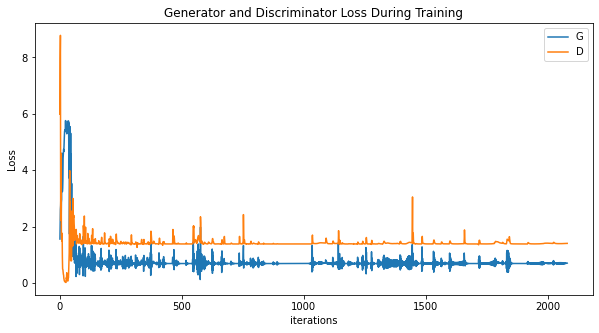

In [0]:
crnngan_curriculum.plot_losses()

Convergence doesn't seem too bad, however, the maximum sequence length is not close to the maximum enough...
Either way, we'll save some songs to see the differences across training iterations

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

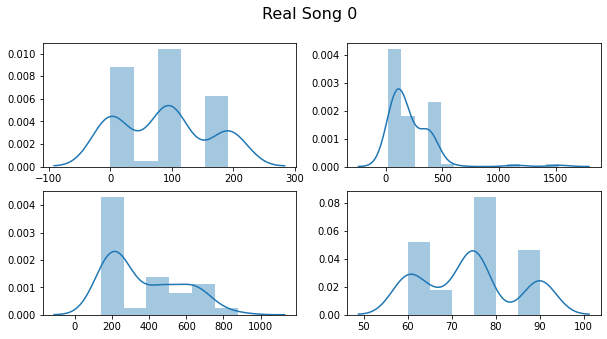

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

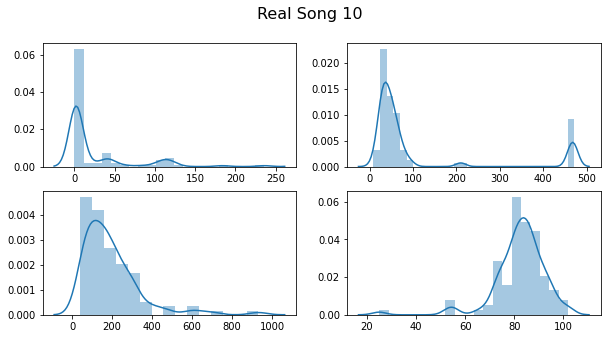

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

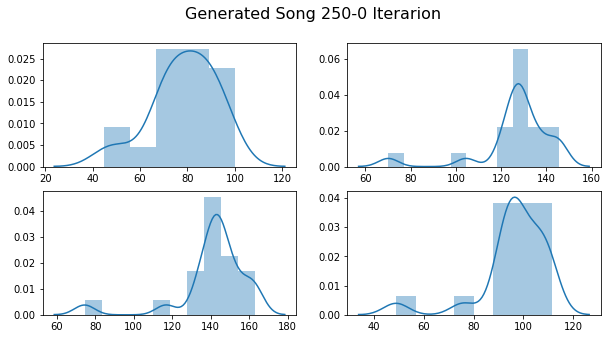

In [0]:
gen_song_250 = crnngan_curriculum.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_250[:,0], ax=axs[0, 0])
sns.distplot(gen_song_250[:,1], ax=axs[0, 1])
sns.distplot(gen_song_250[:,2], ax=axs[1, 0])
sns.distplot(gen_song_250[:,3], ax=axs[1, 1])

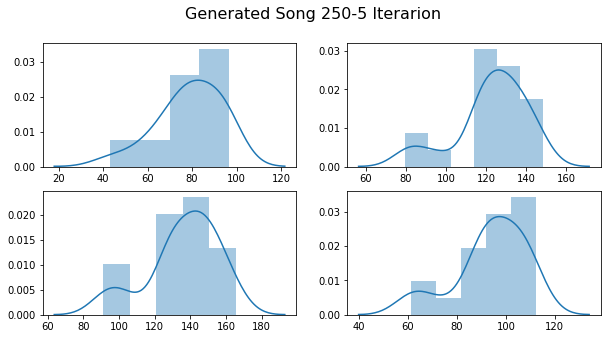

In [0]:
gen_song_250_5 = crnngan_curriculum.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-5 Iterarion', fontsize=16)
sns.distplot(gen_song_250_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_250_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_250_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_250_5[:,3], ax=axs[1, 1])

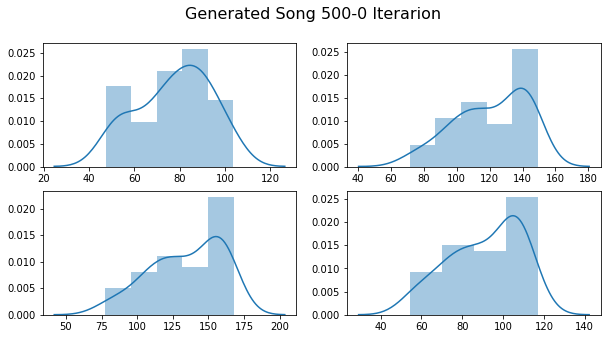

In [0]:
gen_song_500 = crnngan_curriculum.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_500[:,0], ax=axs[0, 0])
sns.distplot(gen_song_500[:,1], ax=axs[0, 1])
sns.distplot(gen_song_500[:,2], ax=axs[1, 0])
sns.distplot(gen_song_500[:,3], ax=axs[1, 1])

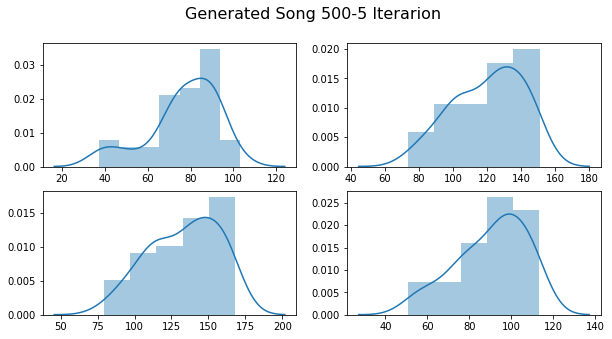

In [0]:
gen_song_500_5 = crnngan_curriculum.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_500_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_500_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_500_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_500_5[:,3], ax=axs[1, 1])

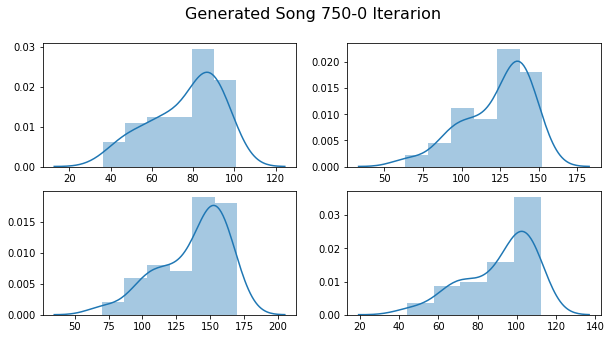

In [0]:
gen_song_750 = crnngan_curriculum.generated_songs[750][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-0 Iterarion', fontsize=16)
sns.distplot(gen_song_750[:,0], ax=axs[0, 0])
sns.distplot(gen_song_750[:,1], ax=axs[0, 1])
sns.distplot(gen_song_750[:,2], ax=axs[1, 0])
sns.distplot(gen_song_750[:,3], ax=axs[1, 1])

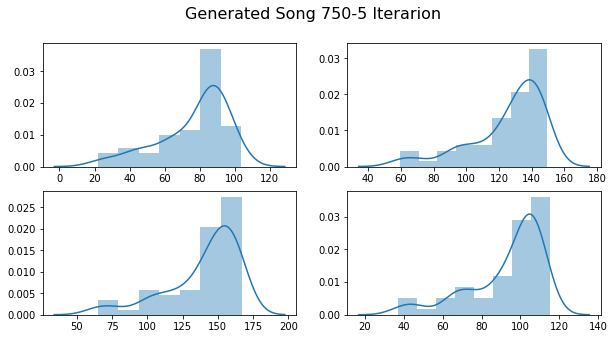

In [0]:
gen_song_750_5 = crnngan_curriculum.generated_songs[750][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-5 Iterarion', fontsize=16)
sns.distplot(gen_song_750_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_750_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_750_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_750_5[:,3], ax=axs[1, 1])

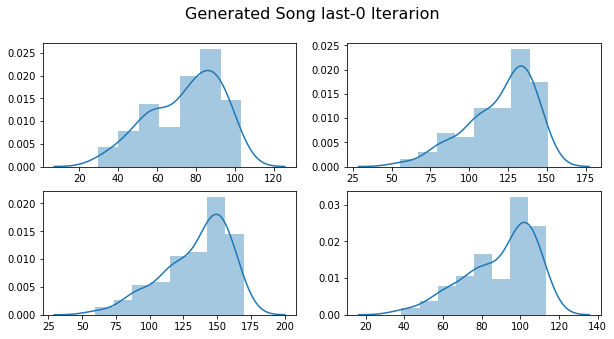

In [0]:
gen_song_last = crnngan_curriculum.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_last[:,3], ax=axs[1, 1])

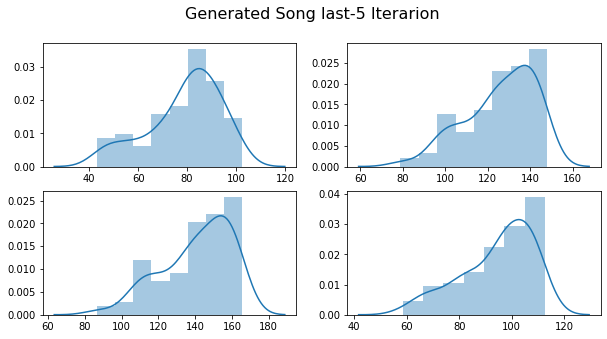

In [0]:
gen_song_last_5 = crnngan_curriculum.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_last_5[:,3], ax=axs[1, 1])

The distributions look good, even higher for the first varibale than what we used to get without curriculum learning. Also, we can see how the more fitted the model is the lesser variance we seem to get in the distributions.

In [0]:
curriculum_save_path = './drive/My Drive/TFM/curriculum_generated_songs'
musicDataLoader.save_data(curriculum_save_path+'/gen_song_250_0.midi', gen_song_250)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_250_5.midi', gen_song_250_5)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_500_0.midi', gen_song_500)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_500_5.midi', gen_song_500_5)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_750_0.midi', gen_song_750)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_750_5.midi', gen_song_750_5)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_last_0.midi', gen_song_last)
musicDataLoader.save_data(curriculum_save_path+'/gen_song_last_5.midi', gen_song_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=63, channel=0, data=[48, 87]),
   midi.NoteOnEvent(tick=85, channel=0, data=[47, 92]),
   midi.NoteOffEvent(tick=36, channel=0, data=[48, 0]),
   midi.NoteOnEvent(tick=53, channel=0, data=[51, 108]),
   midi.NoteOffEvent(tick=30, channel=0, data=[47, 0]),
   midi.NoteOnEvent(tick=67, channel=0, data=[50, 108]),
   midi.NoteOffEvent(tick=49, channel=0, data=[51, 0]),
   midi.NoteOnEvent(tick=35, channel=0, data=[49, 97]),
   midi.NoteOnEvent(tick=51, channel=0, data=[44, 68]),
   midi.NoteOffEvent(tick=2, channel=0, data=[50, 0]),
   midi.NoteOnEvent(tick=57, channel=0, data=[48, 84]),
   midi.NoteOffEvent(tick=16, channel=0, data=[49, 0]),
   midi.NoteOffEvent(tick=17, channel=0, data=[44, 0]),
   midi.NoteOnEvent(tick=58, channel=0, data=[50, 107]),
   midi.NoteOffEvent(tick=28, channel=0, data=[48, 0]),
   midi.NoteOnEvent(tick=43, channel=0, data=[

TODO: Comment on listenings

## Deeper simple architecture (3 layers deep both)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 80
curriculum_learning = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 max_sequence_length = max_sequence_length,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold)

cuda


In [0]:
crnngan_curriculum_deep.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 6.0021	Loss_G: 5.2139	D(x): -2.9870	D(G(z)): -2.9951 / -0.0001
 Time since epoch started: 0.07
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 3.8377	Loss_G: 2.0009	D(x): -0.3382	D(G(z)): -0.3322 / -0.5986
 Time since epoch started: 0.57
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 3.4162	Loss_G: 1.6828	D(x): -0.6066	D(G(z)): -0.6066 / -0.5792
 Time since epoch started: 1.06
There are a total of 10 fake songs saved already
Epoch time: 1.32
[1/80][30]	Loss_D: 3.8561	Loss_G: 1.6947	D(x): -1.8199	D(G(z)): -1.7888 / -0.2612
 Time since epoch started: 0.25
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 2.5870	Loss_G: 0.9877	D(x): -0.2394	D(G(z)): -0.2594 / -0.9345
 Time since epoch started: 0.74
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.9231	Loss_G: 0.8933	D(x): -0.6002	D(G(z)): -0.6002 / -0.6488
 Time since epoch started: 1.23
There are a total of 25 fake

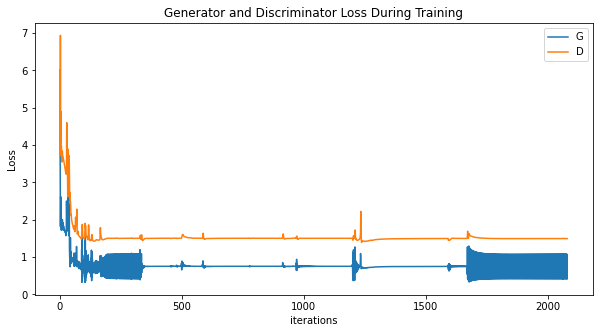

In [0]:
crnngan_curriculum_deep.plot_losses()

Great convergence, we've reached maximum length quite fast, however, toward the end we seem to get worse. To visualize the difference we'll save songs at 4 iterations (250, 500, 830 and the last one).

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

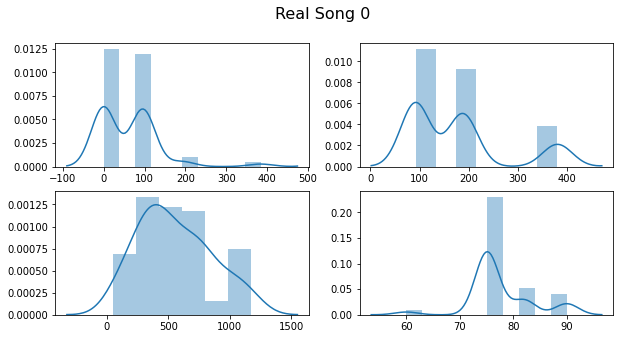

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

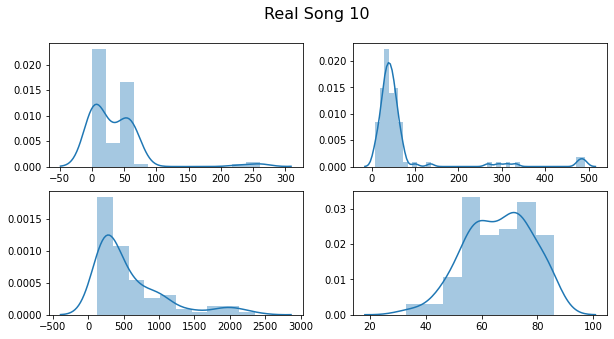

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

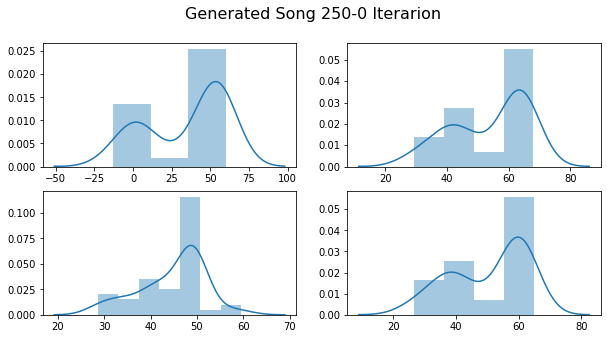

In [0]:
gen_song_curriculum_deep_250 = crnngan_curriculum_deep.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_250[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_250[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_250[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_250[:,3], ax=axs[1, 1])

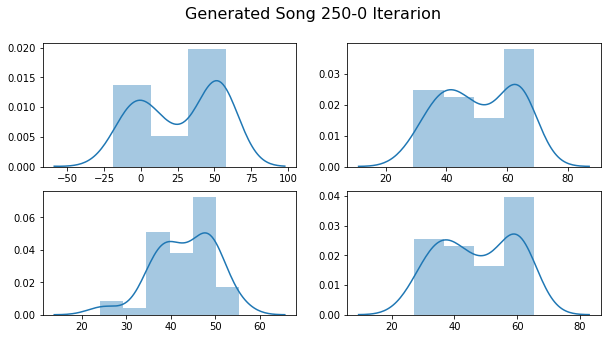

In [0]:
gen_song_curriculum_deep_250_5 = crnngan_curriculum_deep.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_250_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_250_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_250_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_250_5[:,3], ax=axs[1, 1])

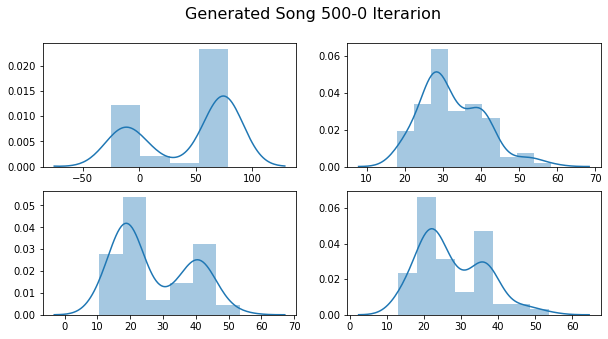

In [0]:
gen_song_curriculum_deep_500 = crnngan_curriculum_deep.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_500[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_500[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_500[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_500[:,3], ax=axs[1, 1])

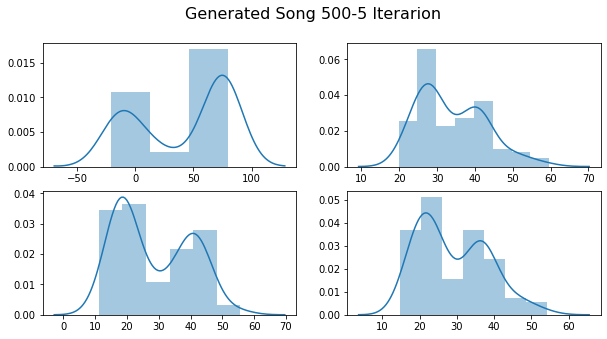

In [0]:
gen_song_curriculum_deep_500_5 = crnngan_curriculum_deep.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_500_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_500_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_500_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_500_5[:,3], ax=axs[1, 1])

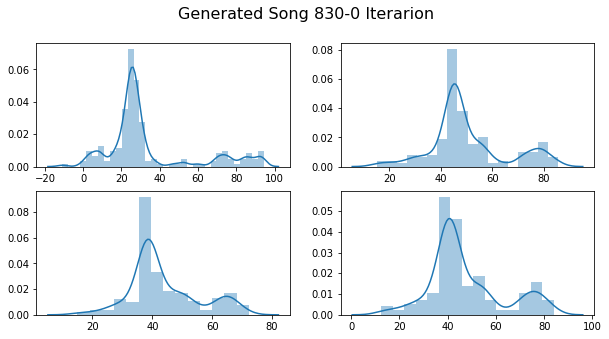

In [0]:
gen_song_curriculum_deep_830 = crnngan_curriculum_deep.generated_songs[830][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 830-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_830[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_830[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_830[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_830[:,3], ax=axs[1, 1])

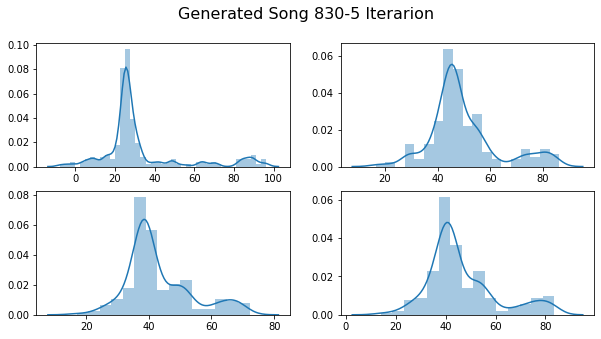

In [0]:
gen_song_curriculum_deep_830_5 = crnngan_curriculum_deep.generated_songs[830][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 830-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_830_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_830_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_830_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_830_5[:,3], ax=axs[1, 1])

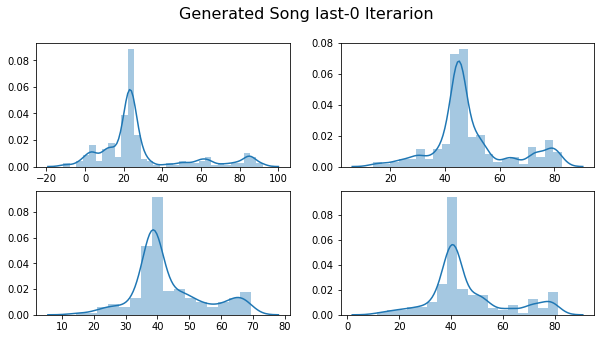

In [0]:
gen_song_curriculum_deep_last = crnngan_curriculum_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_last[:,3], ax=axs[1, 1])

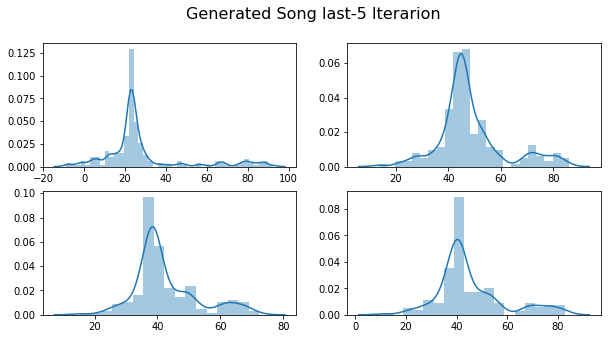

In [0]:
gen_song_curriculum_deep_last_5 = crnngan_curriculum_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_deep_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_deep_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_deep_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_deep_last_5[:,3], ax=axs[1, 1])

These distributions look OK, however, they seem a bit weird as variables are too similar amongst them, and towards the end the seem to have a very low variance, leading up to very thin distributions.

In [0]:
save_path = './drive/My Drive/TFM/curriculum_deep_generated_songs'
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_250_0.midi', gen_song_curriculum_deep_250)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_250_5.midi', gen_song_curriculum_deep_250_5)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_500_0.midi', gen_song_curriculum_deep_500)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_500_5.midi', gen_song_curriculum_deep_500_5)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_830_0.midi', gen_song_curriculum_deep_830)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_830_5.midi', gen_song_curriculum_deep_830_5)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_last_0.midi', gen_song_curriculum_deep_last)
musicDataLoader.save_data(save_path+'/gen_song_curriculum_deep_last_5.midi', gen_song_curriculum_deep_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=25, channel=0, data=[27, 43]),
   midi.NoteOnEvent(tick=24, channel=0, data=[28, 45]),
   midi.NoteOffEvent(tick=23, channel=0, data=[27, 0]),
   midi.NoteOnEvent(tick=5, channel=0, data=[27, 44]),
   midi.NoteOffEvent(tick=21, channel=0, data=[28, 0]),
   midi.NoteOnEvent(tick=0, channel=0, data=[24, 36]),
   midi.NoteOnEvent(tick=23, channel=0, data=[25, 37]),
   midi.NoteOffEvent(tick=5, channel=0, data=[27, 0]),
   midi.NoteOffEvent(tick=12, channel=0, data=[24, 0]),
   midi.NoteOffEvent(tick=25, channel=0, data=[25, 0]),
   midi.NoteOnEvent(tick=35, channel=0, data=[35, 75]),
   midi.NoteOnEvent(tick=17, channel=0, data=[24, 37]),
   midi.NoteOnEvent(tick=37, channel=0, data=[30, 52]),
   midi.NoteOffEvent(tick=1, channel=0, data=[24, 0]),
   midi.NoteOffEvent(tick=22, channel=0, data=[35, 0]),
   midi.NoteOnEvent(tick=2, channel=0, data=[25, 37]

TODO: Comment on the listening.

## Complex generator (2 layers deep both)



In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
max_sequence_length = 200
complexGenerator = True
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_complex_generator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator, max_sequence_length=max_sequence_length,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold)

cuda
Complex Generator


In [0]:
crnngan_curriculum_complex_generator.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9961	Loss_G: 3.3891	D(x): -2.9534	D(G(z)): -2.9949 / -0.0007
 Time since epoch started: 0.06
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 2.1041	Loss_G: 5.3517	D(x): -1.3732	D(G(z)): -0.1994 / -0.0743
 Time since epoch started: 0.45
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 0.7654	Loss_G: 4.1391	D(x): -0.5184	D(G(z)): -0.2350 / -0.1940
 Time since epoch started: 0.82
There are a total of 10 fake songs saved already
Epoch time: 1.01
[1/80][30]	Loss_D: 0.1218	Loss_G: 6.4223	D(x): -0.0490	D(G(z)): -0.0728 / -0.0596
 Time since epoch started: 0.19
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 0.5236	Loss_G: 5.1361	D(x): -0.0227	D(G(z)): -0.0870 / -0.1420
 Time since epoch started: 0.55
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 2.0532	Loss_G: 4.2838	D(x): -0.1509	D(G(z)): -0.2004 / -0.2396
 Time since epoch started: 0.93
There are a total of 25 fake

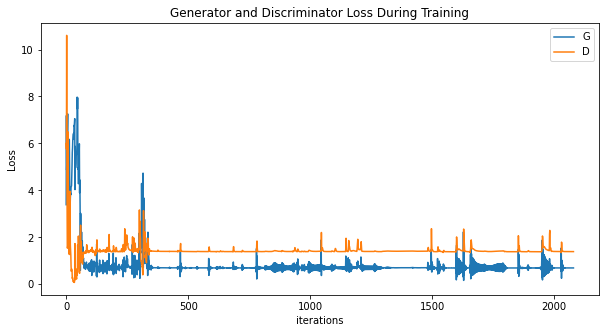

In [0]:
crnngan_curriculum_complex_generator.plot_losses()

Convergence looks about right. Let's see how the generated song look like.

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

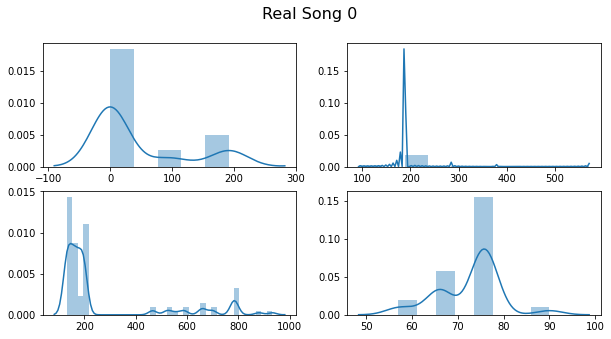

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

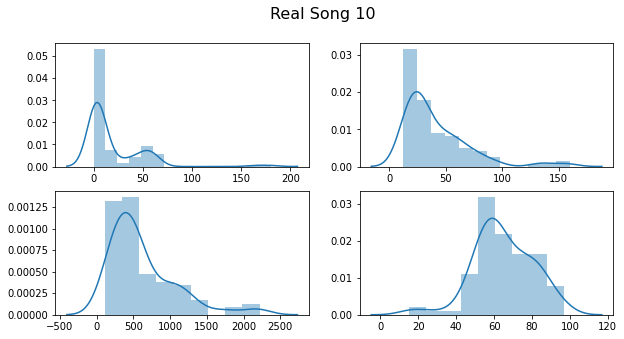

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

It happens very often that there are lot's of 0 values in the first variable, which probably means that no note is played. Also, there seems like there are several heaps in the first variable which we don't seem to get quite right...

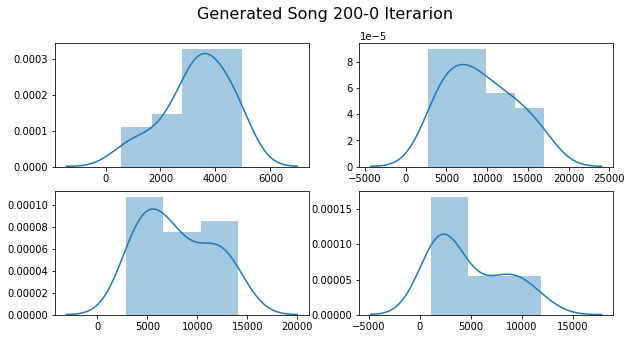

In [0]:
gen_song_curriculum_complex_generator_200 = crnngan_curriculum_complex_generator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_200[:,3], ax=axs[1, 1])

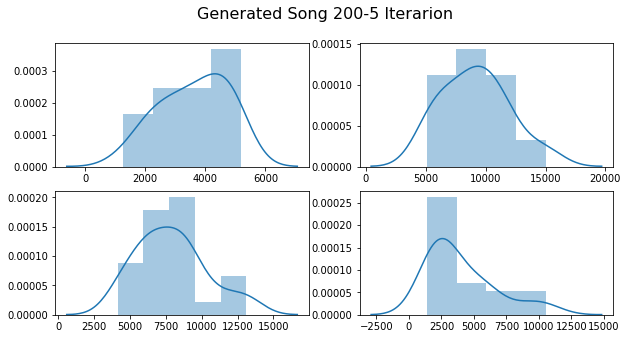

In [0]:
gen_song_curriculum_complex_generator_200_5 = crnngan_curriculum_complex_generator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_5[:,3], ax=axs[1, 1])

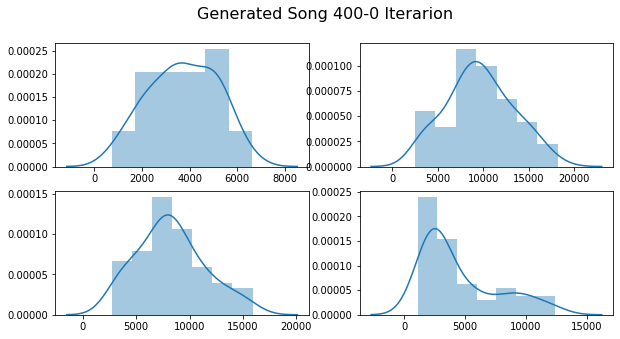

In [0]:
gen_song_curriculum_complex_generator_400 = crnngan_curriculum_complex_generator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_400[:,3], ax=axs[1, 1])

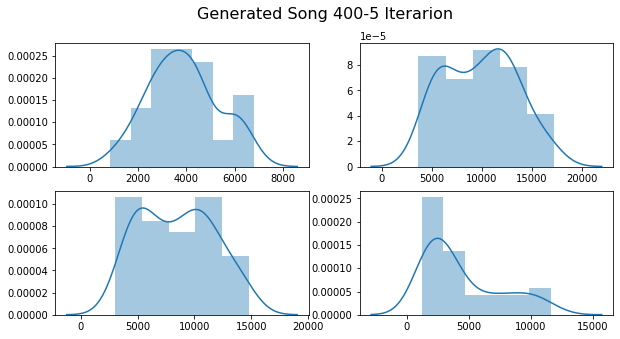

In [0]:
gen_song_curriculum_complex_generator_400_5 = crnngan_curriculum_complex_generator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_5[:,3], ax=axs[1, 1])

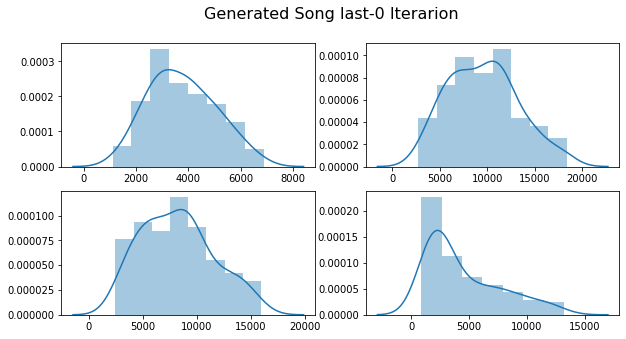

In [0]:
gen_song_curriculum_complex_generator_last = crnngan_curriculum_complex_generator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_last[:,3], ax=axs[1, 1])

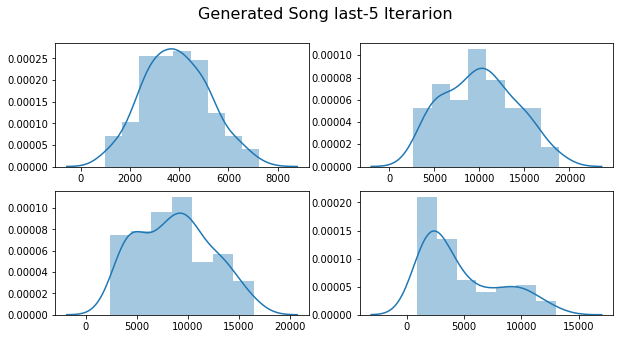

In [0]:
gen_song_curriculum_complex_generator_last_5 = crnngan_curriculum_complex_generator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_5[:,3], ax=axs[1, 1])

Too large values...

## Complex generator (3 layers deep discriminator)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 80
curriculum_learning = True
complexGenerator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_complex_generator_deep_discr = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator, max_sequence_length=max_sequence_length,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold)

cuda
Complex Generator


In [0]:
crnngan_curriculum_complex_generator_deep_discr.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9716	Loss_G: 4.1355	D(x): -2.9765	D(G(z)): -2.9892 / -0.0013
 Time since epoch started: 0.06
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 3.7512	Loss_G: 1.8700	D(x): -0.7236	D(G(z)): -0.7088 / -0.3970
 Time since epoch started: 0.53
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 3.3957	Loss_G: 1.6273	D(x): -0.5356	D(G(z)): -0.5356 / -0.6315
 Time since epoch started: 1.01
There are a total of 10 fake songs saved already
Epoch time: 1.24
[1/80][30]	Loss_D: 8.8397	Loss_G: 1.9074	D(x): -0.0003	D(G(z)): -0.0058 / -1.6772
 Time since epoch started: 0.22
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 2.6546	Loss_G: 1.2502	D(x): -0.3613	D(G(z)): -0.3613 / -1.2489
 Time since epoch started: 0.69
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.9605	Loss_G: 0.9440	D(x): -0.4320	D(G(z)): -0.4320 / -0.9440
 Time since epoch started: 1.14
There are a total of 25 fake

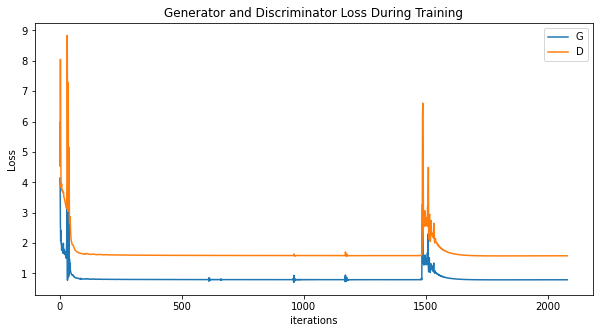

In [0]:
crnngan_curriculum_complex_generator_deep_discr.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

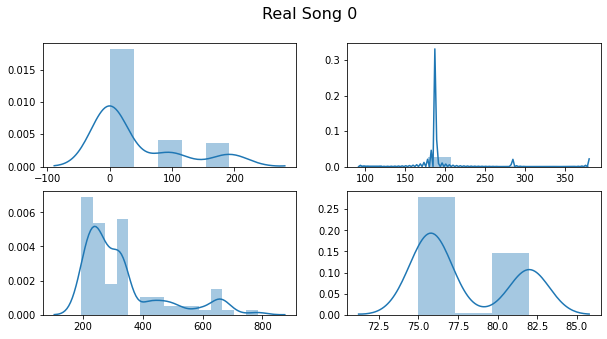

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

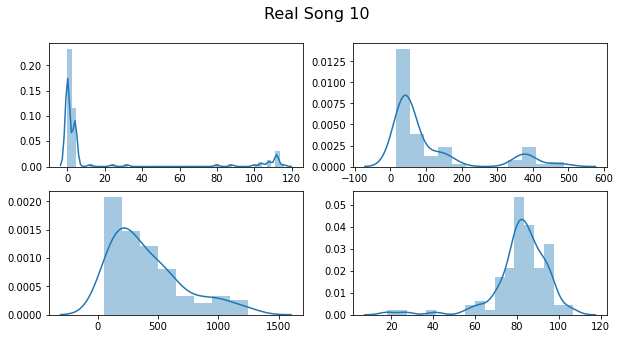

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

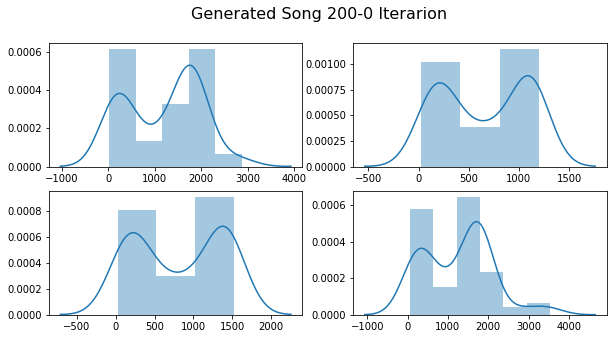

In [0]:
gen_song_curriculum_complex_generator_200_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_200_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_200_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_deep_discr[:,3], ax=axs[1, 1])

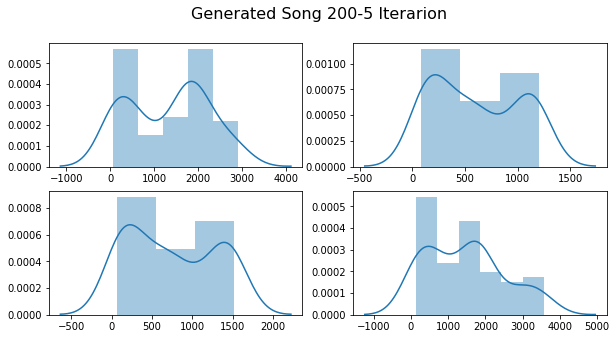

In [0]:
gen_song_curriculum_complex_generator_200_5_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_200_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_200_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_200_5_deep_discr[:,3], ax=axs[1, 1])

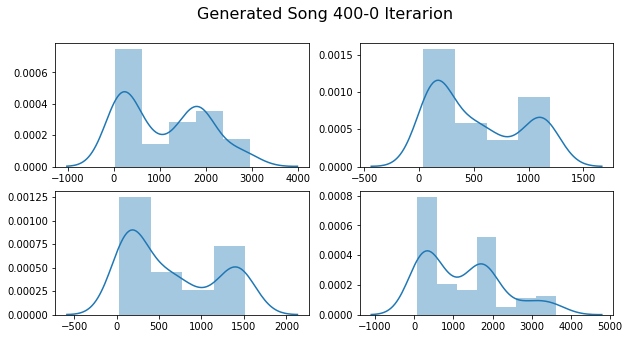

In [0]:
gen_song_curriculum_complex_generator_400_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_400_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_400_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_deep_discr[:,3], ax=axs[1, 1])

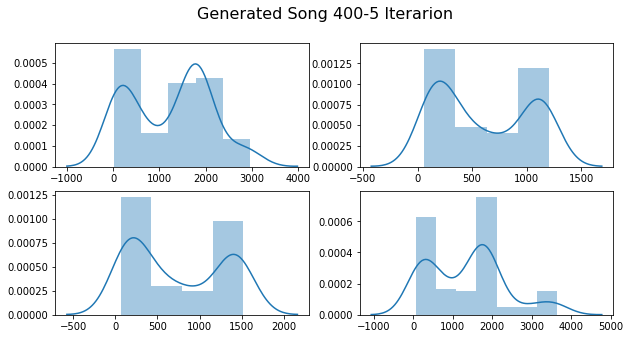

In [0]:
gen_song_curriculum_complex_generator_400_5_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_400_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_400_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_400_5_deep_discr[:,3], ax=axs[1, 1])

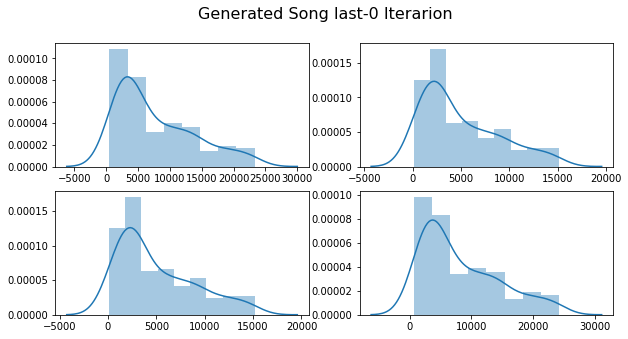

In [0]:
gen_song_curriculum_complex_generator_last_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_last_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_last_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_deep_discr[:,3], ax=axs[1, 1])

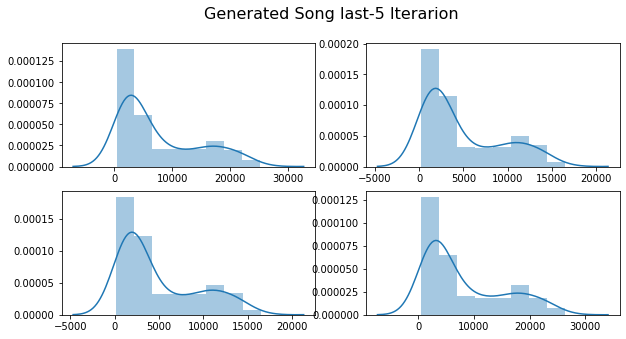

In [0]:
gen_song_curriculum_complex_generator_last_5_deep_discr = crnngan_curriculum_complex_generator_deep_discr.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_curriculum_complex_generator_last_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_curriculum_complex_generator_last_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_curriculum_complex_generator_last_5_deep_discr[:,3], ax=axs[1, 1])

The values are too large, which makes these songs totally worthless.

## Complex generator (3 layers deep both)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 80
curriculum_learning = True
complexGenerator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_complex_generator_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator, max_sequence_length=max_sequence_length,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold)

cuda
Complex Generator


In [0]:
crnngan_curriculum_complex_generator_deep.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9931	Loss_G: 4.5510	D(x): -2.9872	D(G(z)): -2.9927 / -0.0004
 Time since epoch started: 0.07
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 3.7611	Loss_G: 1.9243	D(x): -0.5042	D(G(z)): -0.5042 / -0.7915
 Time since epoch started: 0.57
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 3.5762	Loss_G: 1.7441	D(x): -0.6059	D(G(z)): -0.6059 / -0.5531
 Time since epoch started: 1.07
There are a total of 10 fake songs saved already
Epoch time: 1.31
[1/80][30]	Loss_D: 3.4838	Loss_G: 1.4096	D(x): -0.6266	D(G(z)): -0.6266 / -0.7947
 Time since epoch started: 0.25
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 3.3213	Loss_G: 1.3089	D(x): -0.6783	D(G(z)): -0.6783 / -0.6325
 Time since epoch started: 0.75
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 3.0205	Loss_G: 1.4923	D(x): -0.4918	D(G(z)): -0.4918 / -0.6687
 Time since epoch started: 1.24
There are a total of 25 fake

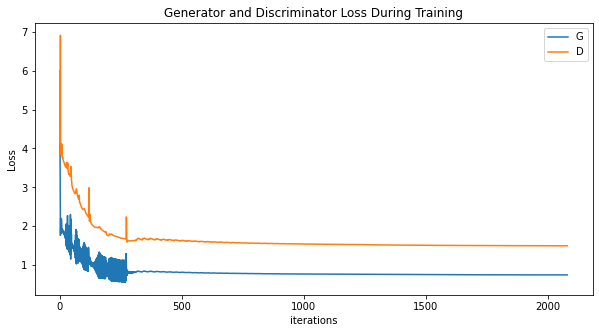

In [0]:
crnngan_curriculum_complex_generator_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

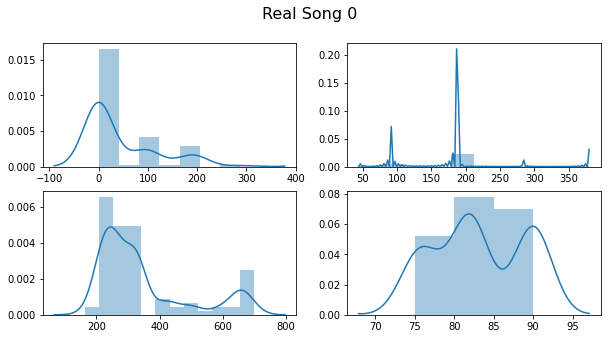

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

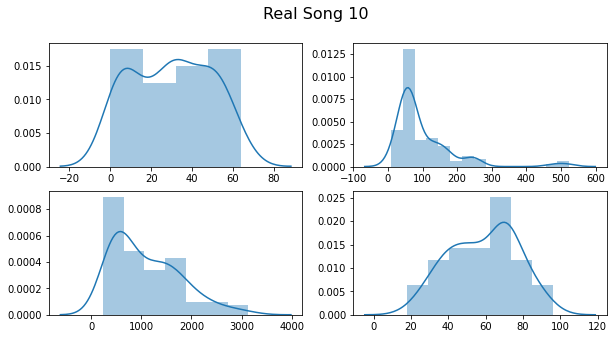

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

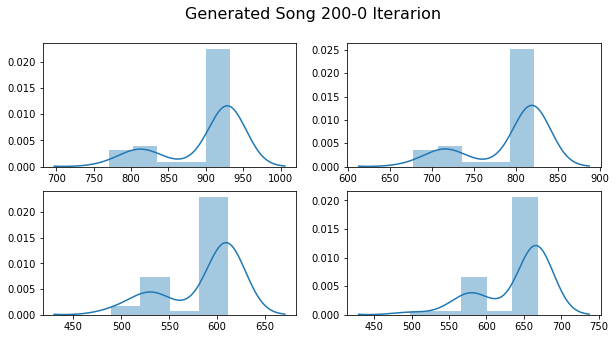

In [0]:
gen_song_complex_generator_200_deep = crnngan_curriculum_complex_generator_deep.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_deep[:,3], ax=axs[1, 1])

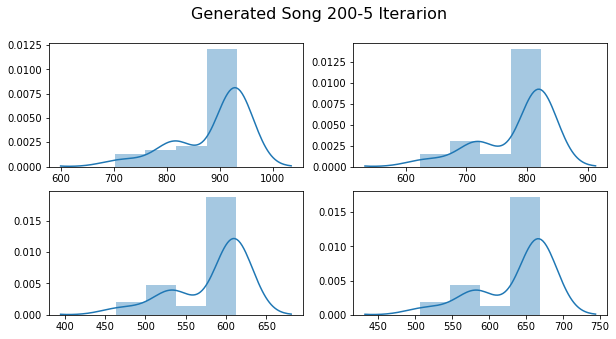

In [0]:
gen_song_complex_generator_200_5_deep = crnngan_curriculum_complex_generator_deep.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_5_deep[:,3], ax=axs[1, 1])

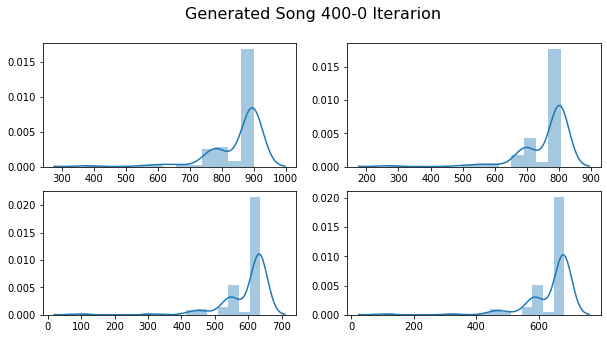

In [0]:
gen_song_complex_generator_400_deep = crnngan_curriculum_complex_generator_deep.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_deep[:,3], ax=axs[1, 1])

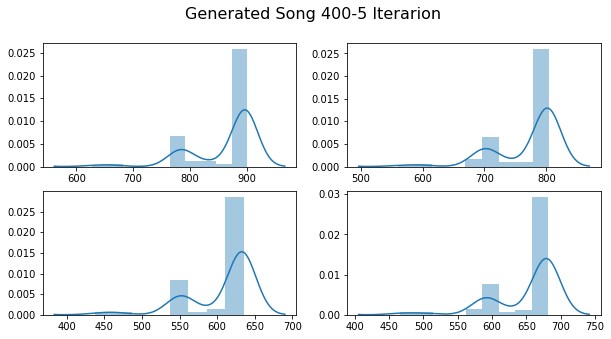

In [0]:
gen_song_complex_generator_400_5_deep = crnngan_curriculum_complex_generator_deep.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_5_deep[:,3], ax=axs[1, 1])

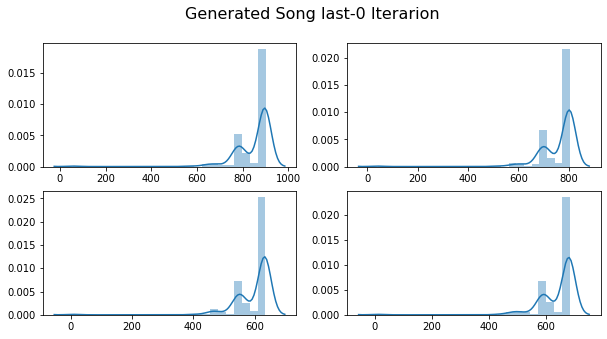

In [0]:
gen_song_complex_generator_last_deep = crnngan_curriculum_complex_generator_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_deep[:,3], ax=axs[1, 1])

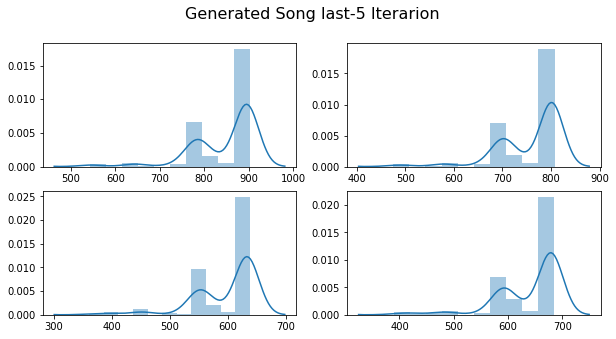

In [0]:
gen_song_complex_generator_last_5_deep = crnngan_curriculum_complex_generator_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_5_deep[:,3], ax=axs[1, 1])

Does not look good as values are still too large...

## Complex discriminator (2 layers deep both)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_complex_discriminator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, max_sequence_length=max_sequence_length,
                 G_var_threshold = G_var_threshold, D_var_threshold = D_var_threshold)

cuda
Complex Discriminator


In [0]:
crnngan_curriculum_complex_discriminator.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9934	Loss_G: 11.5104	D(x): -2.9797	D(G(z)): -2.9952 / 0.0000
 Time since epoch started: 0.13
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 1.0951	Loss_G: 143.9850	D(x): -0.0011	D(G(z)): -0.4463 / -0.8420
 Time since epoch started: 1.14
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 0.0001	Loss_G: 150.4474	D(x): -0.0001	D(G(z)): 0.0000 / 0.0000
 Time since epoch started: 2.08
There are a total of 10 fake songs saved already
Epoch time: 2.56
[1/80][30]	Loss_D: 0.0000	Loss_G: 149.0570	D(x): -0.0000	D(G(z)): 0.0000 / 0.0000
 Time since epoch started: 0.46
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 0.0000	Loss_G: 150.7615	D(x): -0.0000	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 1.40
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.6362	Loss_G: 137.7462	D(x): -0.0000	D(G(z)): -0.0065 / -0.0000
 Time since epoch started: 2.34
There are a total of 2

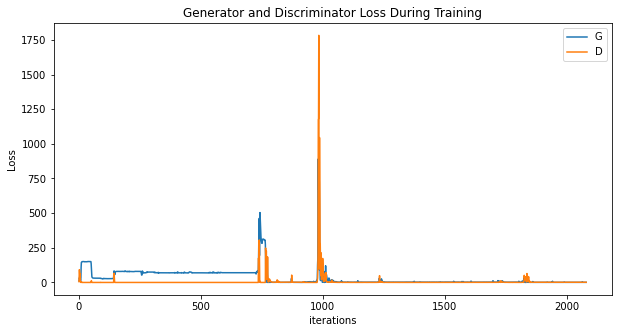

In [0]:
crnngan_curriculum_complex_discriminator.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

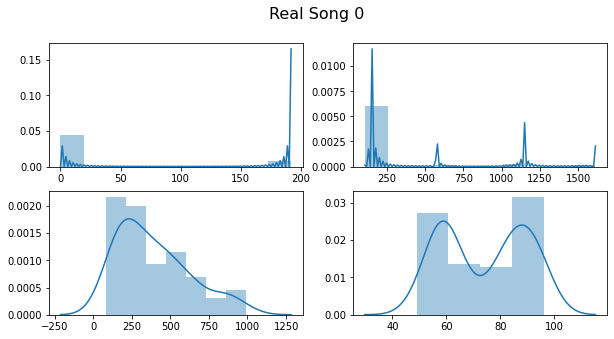

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

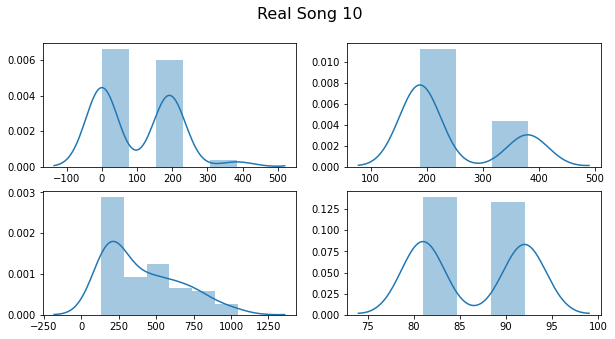

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

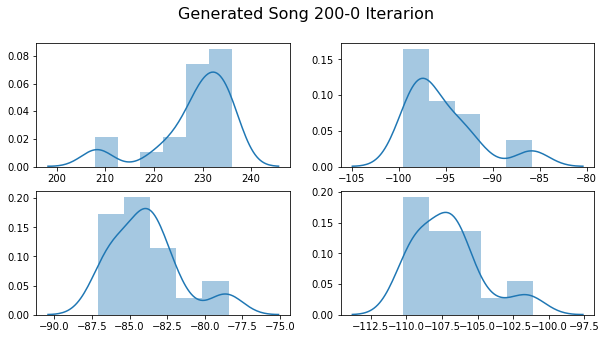

In [0]:
gen_song_complex_discriminator_200 = crnngan_curriculum_complex_discriminator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200[:,3], ax=axs[1, 1])

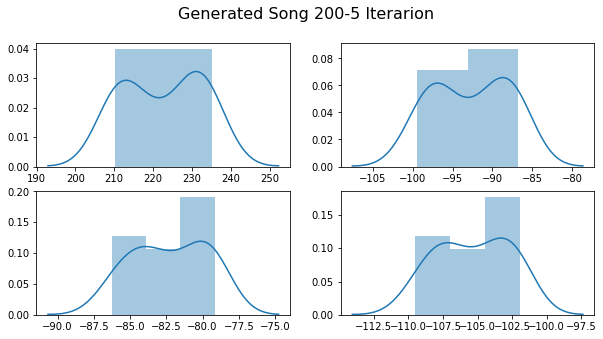

In [0]:
gen_song_complex_discriminator_200_5 = crnngan_curriculum_complex_discriminator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_5[:,3], ax=axs[1, 1])

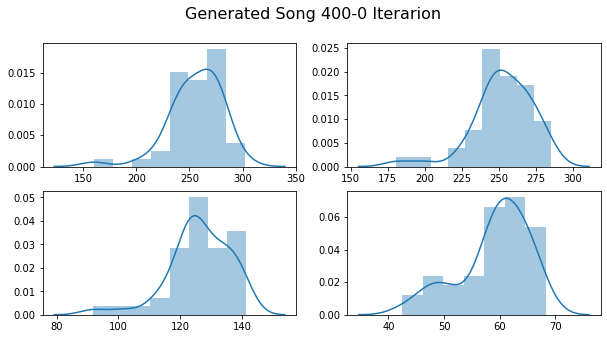

In [0]:
gen_song_complex_discriminator_400 = crnngan_curriculum_complex_discriminator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400[:,3], ax=axs[1, 1])

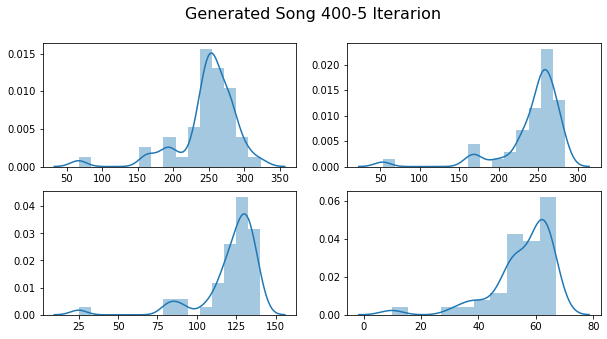

In [0]:
gen_song_complex_discriminator_400_5 = crnngan_curriculum_complex_discriminator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_5[:,3], ax=axs[1, 1])

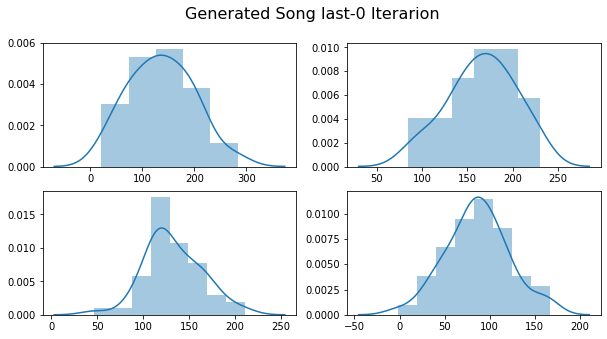

In [0]:
gen_song_complex_discriminator_last = crnngan_curriculum_complex_discriminator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last[:,3], ax=axs[1, 1])

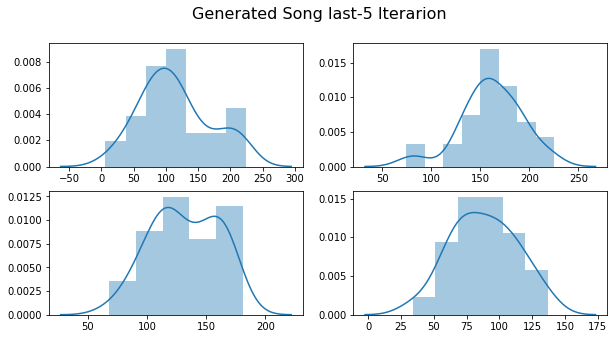

In [0]:
gen_song_complex_discriminator_last_5 = crnngan_curriculum_complex_discriminator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5[:,3], ax=axs[1, 1])

These distributions don't look bad so we'll save the generated songs so we can listen them and see if they are any good.

In [0]:
save_path = './drive/My Drive/TFM/curriculum_complex_discriminator'
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_200_0.midi', gen_song_complex_discriminator_200)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_200_5.midi', gen_song_complex_discriminator_200_5)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_400_0.midi', gen_song_complex_discriminator_400)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_400_5.midi', gen_song_complex_discriminator_400_5)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_last_0.midi', gen_song_complex_discriminator_last)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_last_5.midi', gen_song_complex_discriminator_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=209, channel=0, data=[47, 60]),
   midi.NoteOnEvent(tick=106, channel=0, data=[51, 127]),
   midi.NoteOffEvent(tick=65, channel=0, data=[47, 0]),
   midi.NoteOnEvent(tick=90, channel=0, data=[52, 96]),
   midi.NoteOffEvent(tick=3, channel=0, data=[51, 0]),
   midi.NoteOnEvent(tick=62, channel=0, data=[49, 110]),
   midi.NoteOnEvent(tick=82, channel=0, data=[48, 101]),
   midi.NoteOffEvent(tick=20, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=59, channel=0, data=[45, 71]),
   midi.NoteOffEvent(tick=9, channel=0, data=[49, 0]),
   midi.NoteOffEvent(tick=53, channel=0, data=[48, 0]),
   midi.NoteOffEvent(tick=90, channel=0, data=[45, 0]),
   midi.NoteOnEvent(tick=30, channel=0, data=[52, 92]),
   midi.NoteOnEvent(tick=85, channel=0, data=[51, 113]),
   midi.NoteOnEvent(tick=25, channel=0, data=[44, 105]),
   midi.NoteOffEvent(tick=77, channel=0, da

This case is not similar to the previous ones as more training doesn't seem to improve the listening quality of the generated songs. This happens both for the '_0' songs and for the '_5' songs. 

Maybe they are better but not thought to be interpreted by only one instrument. Either way, we'll try increasing the complexity a bit to see if anything improves.

## Complex discriminator (3 layers deep generator)

In [0]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
max_sequence_length = 200

crnngan_curriculum_complex_discriminator_deep_gen = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, max_sequence_length=max_sequence_length)

cuda
Complex Discriminator


In [0]:
crnngan_curriculum_complex_discriminator_deep_gen.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9997	Loss_G: 8.0366	D(x): -2.9824	D(G(z)): -2.9951 / -0.0000
 Time since epoch started: 0.04
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 0.9691	Loss_G: 16.8413	D(x): -0.0803	D(G(z)): -0.0384 / -0.0005
 Time since epoch started: 0.43
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 1.9512	Loss_G: 5.6688	D(x): -0.2452	D(G(z)): -0.1967 / -0.0056
 Time since epoch started: 0.81
There are a total of 10 fake songs saved already
Epoch time: 1.00
[1/80][30]	Loss_D: 0.9682	Loss_G: 1.1621	D(x): -0.5639	D(G(z)): -0.3158 / -0.3089
 Time since epoch started: 0.19
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 1.8029	Loss_G: 3.9326	D(x): -0.2963	D(G(z)): -0.3611 / -0.1219
 Time since epoch started: 0.56
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 0.9083	Loss_G: 0.4929	D(x): -0.4328	D(G(z)): -0.3721 / -0.4442
 Time since epoch started: 0.94
There are a total of 25 fak

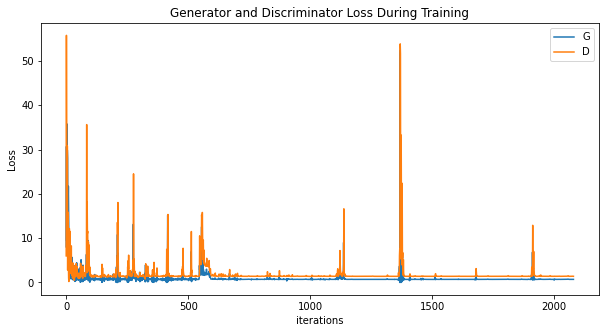

In [0]:
crnngan_curriculum_complex_discriminator_deep_gen.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

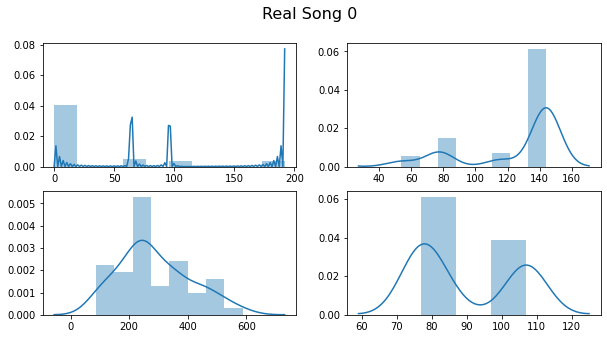

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

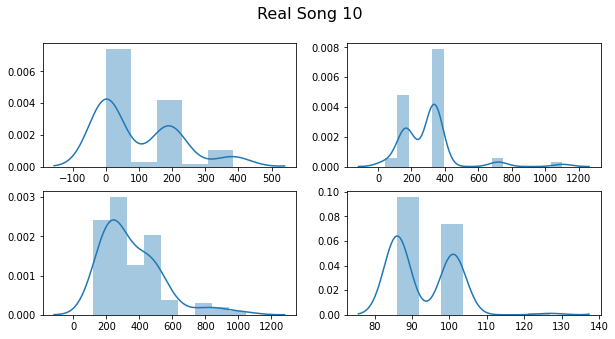

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

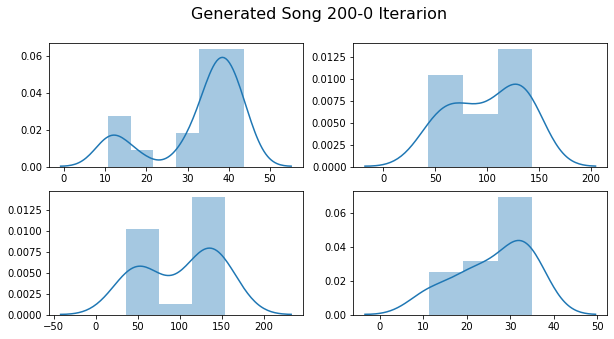

In [0]:
gen_song_complex_discriminator_200_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_deep_gen[:,3], ax=axs[1, 1])

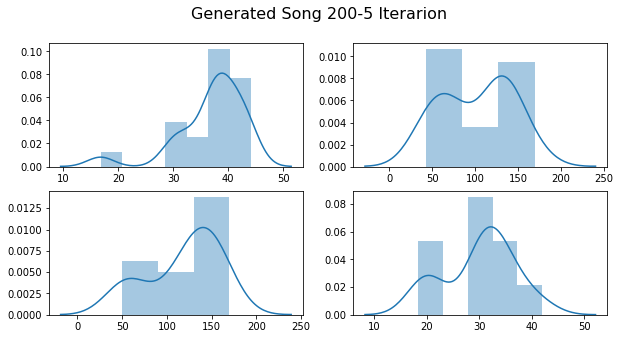

In [0]:
gen_song_complex_discriminator_200_5_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_5_deep_gen[:,3], ax=axs[1, 1])

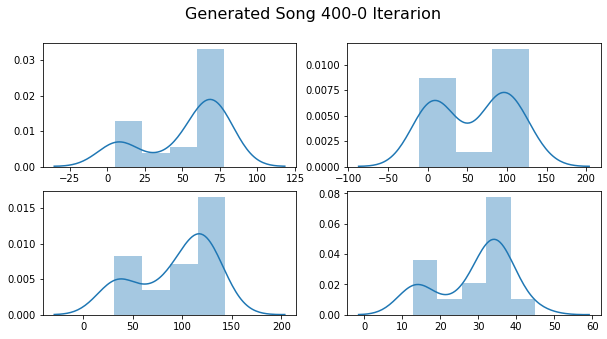

In [0]:
gen_song_complex_discriminator_400_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_deep_gen[:,3], ax=axs[1, 1])

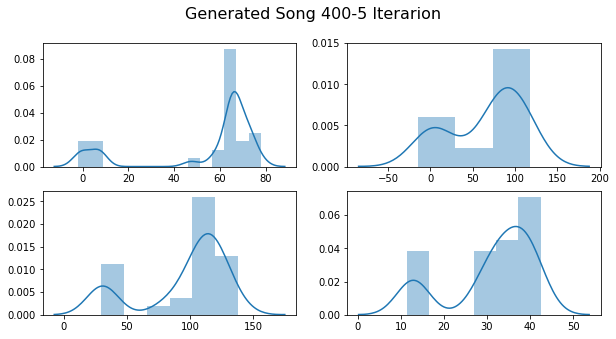

In [0]:
gen_song_complex_discriminator_400_5_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_5_deep_gen[:,3], ax=axs[1, 1])

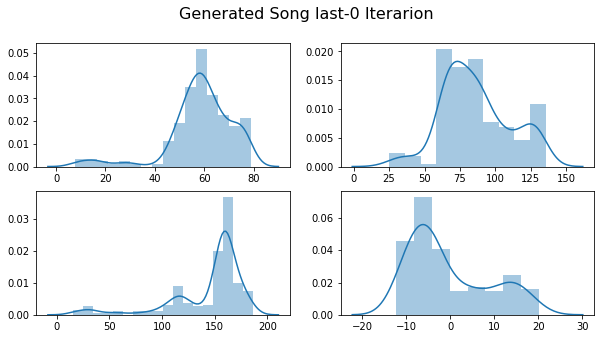

In [0]:
gen_song_complex_discriminator_last_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_deep_gen[:,3], ax=axs[1, 1])

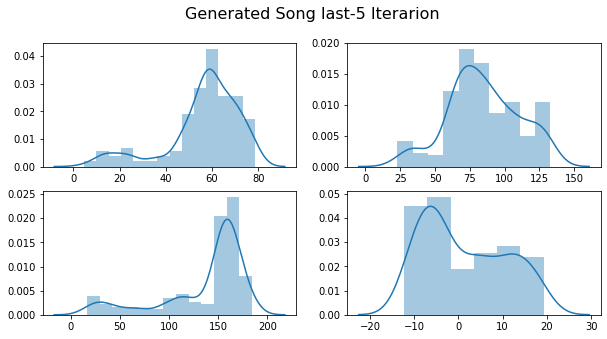

In [0]:
gen_song_complex_discriminator_last_5_deep_gen = crnngan_curriculum_complex_discriminator_deep_gen.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep_gen[:,3], ax=axs[1, 1])

The convergence graph and the distribution graphs look good se we'll save the songs so that we can listen to them.

In [0]:
save_path = './drive/My Drive/TFM/curriculum_complex_discriminator_deep_gen'
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_200_0.midi', gen_song_complex_discriminator_200_deep_gen)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_200_5.midi', gen_song_complex_discriminator_200_5_deep_gen)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_400_0.midi', gen_song_complex_discriminator_400_deep_gen)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_400_5.midi', gen_song_complex_discriminator_400_5_deep_gen)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_last_0.midi', gen_song_complex_discriminator_last_deep_gen)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_gen_last_5.midi', gen_song_complex_discriminator_last_5_deep_gen)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=17, channel=0, data=[23, 5]),
   midi.NoteOffEvent(tick=38, channel=0, data=[23, 0]),
   midi.NoteOnEvent(tick=19, channel=0, data=[46, 17]),
   midi.NoteOnEvent(tick=67, channel=0, data=[51, 5]),
   midi.NoteOffEvent(tick=28, channel=0, data=[46, 0]),
   midi.NoteOffEvent(tick=74, channel=0, data=[51, 0]),
   midi.NoteOnEvent(tick=96, channel=0, data=[52, 12]),
   midi.NoteOnEvent(tick=33, channel=0, data=[36, 6]),
   midi.NoteOnEvent(tick=37, channel=0, data=[35, 6]),
   midi.NoteOnEvent(tick=11, channel=0, data=[15, 3]),
   midi.NoteOffEvent(tick=27, channel=0, data=[52, 0]),
   midi.NoteOffEvent(tick=3, channel=0, data=[15, 0]),
   midi.NoteOffEvent(tick=10, channel=0, data=[36, 0]),
   midi.NoteOffEvent(tick=40, channel=0, data=[35, 0]),
   midi.NoteOnEvent(tick=27, channel=0, data=[42, 17]),
   midi.NoteOffEvent(tick=89, channel=0, data=[42, 0])

These songs seem to follow more patterns than those generated previously, which means this structure is good. We'll not try making it a bit deeper.

With respect to the difference between samples generated with a more or a less trained version, we see some differences however, they are bearely noticeable by listening to them...

## Complex discriminator (3 layers deep both)

In [25]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_complex_discriminator_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, G_var_threshold=G_var_threshold,
                 D_var_threshold=D_var_threshold, max_sequence_length=max_sequence_length)

cuda
Complex Discriminator


In [26]:
crnngan_curriculum_complex_discriminator_deep.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9904	Loss_G: 28.5408	D(x): -2.9909	D(G(z)): -2.9954 / 0.0000
 Time since epoch started: 0.05
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 4.1411	Loss_G: 2.3753	D(x): -1.3946	D(G(z)): -1.3893 / -1.0555
 Time since epoch started: 0.53
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 3.0847	Loss_G: 1.0000	D(x): -0.6068	D(G(z)): -0.6068 / -0.5743
 Time since epoch started: 0.98
There are a total of 10 fake songs saved already
Epoch time: 1.21
[1/80][30]	Loss_D: 1.5230	Loss_G: 1.1901	D(x): -0.4620	D(G(z)): -0.4621 / -0.1637
 Time since epoch started: 0.23
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 1.7145	Loss_G: 0.9154	D(x): -0.5512	D(G(z)): -0.5512 / -0.2655
 Time since epoch started: 0.68
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.7967	Loss_G: 1.0713	D(x): -0.4101	D(G(z)): -0.4091 / -0.2648
 Time since epoch started: 1.14
There are a total of 25 fake

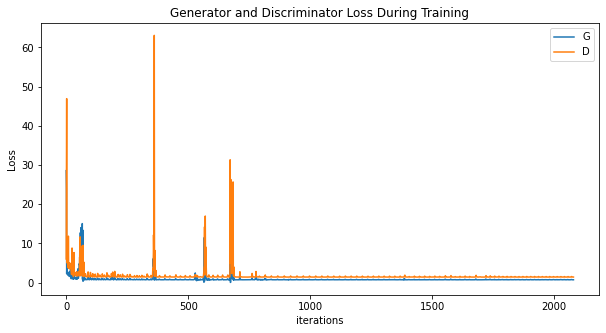

In [27]:
crnngan_curriculum_complex_discriminator_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


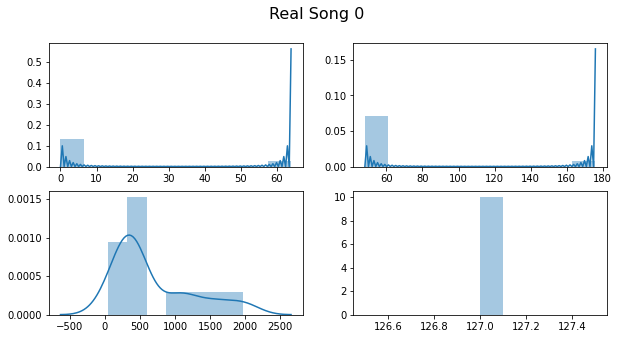

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

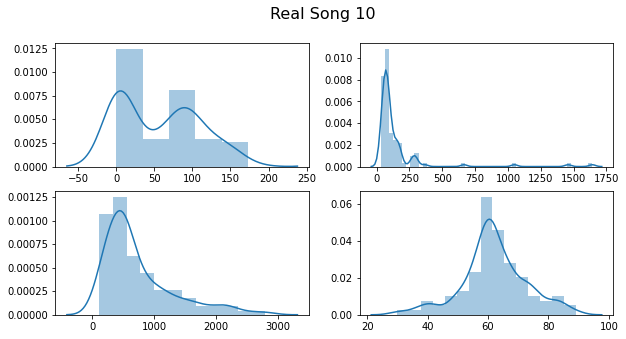

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

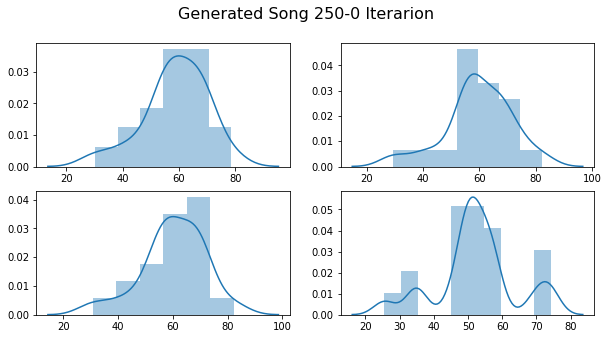

In [31]:
gen_song_complex_discriminator_250_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_250_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_250_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_250_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_250_deep[:,3], ax=axs[1, 1])

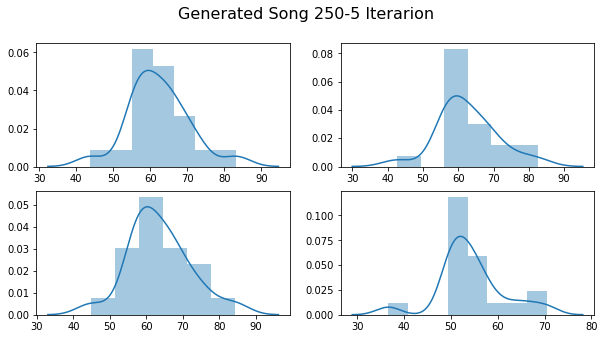

In [32]:
gen_song_complex_discriminator_250_5_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_250_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_250_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_250_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_250_5_deep[:,3], ax=axs[1, 1])

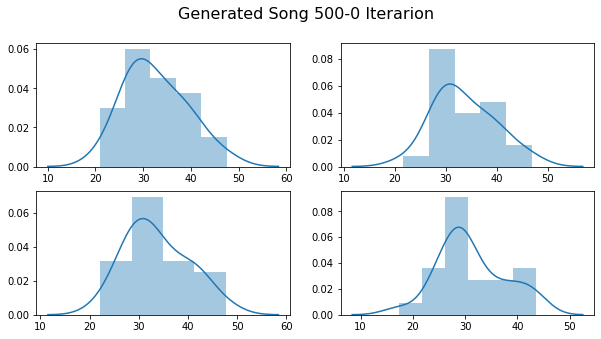

In [33]:
gen_song_complex_discriminator_500_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_500_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_500_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_500_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_500_deep[:,3], ax=axs[1, 1])

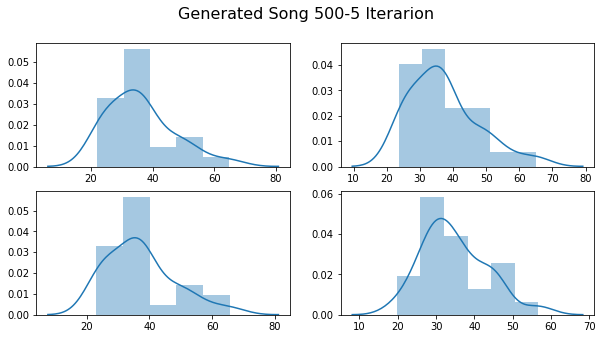

In [34]:
gen_song_complex_discriminator_500_5_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_500_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_500_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_500_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_500_5_deep[:,3], ax=axs[1, 1])

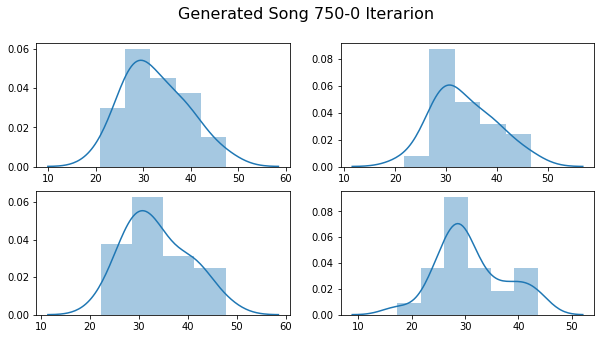

In [35]:
gen_song_complex_discriminator_750_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[750][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_750_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_750_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_750_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_750_deep[:,3], ax=axs[1, 1])

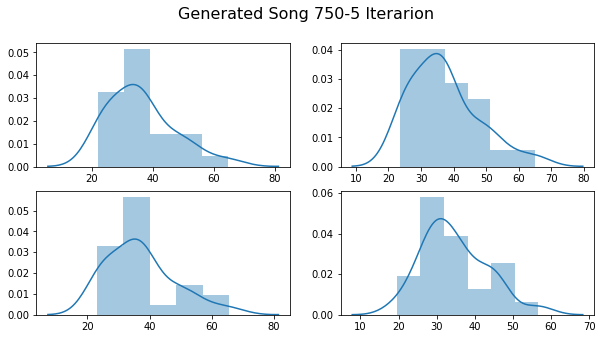

In [36]:
gen_song_complex_discriminator_750_5_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[750][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_750_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_750_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_750_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_750_5_deep[:,3], ax=axs[1, 1])

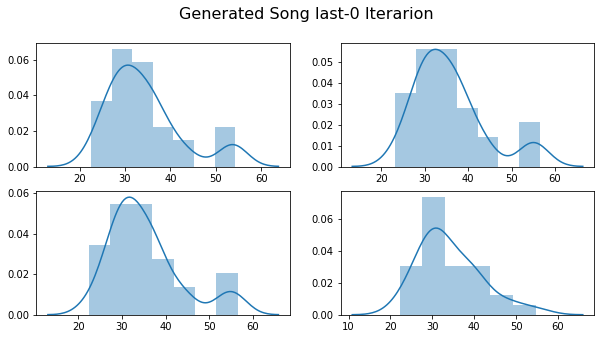

In [37]:
gen_song_complex_discriminator_last_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_deep[:,3], ax=axs[1, 1])

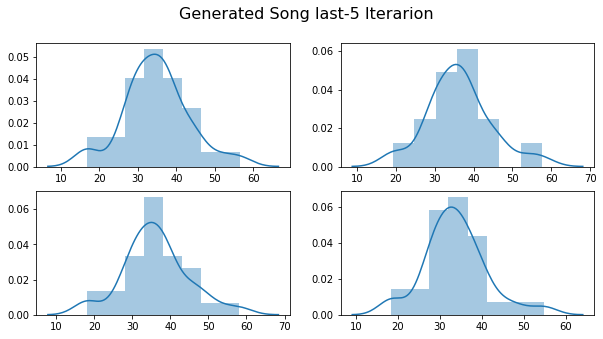

In [38]:
gen_song_complex_discriminator_last_5_deep = crnngan_curriculum_complex_discriminator_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,3], ax=axs[1, 1])

All features look too similar when compared amongst themselves.

## Both complex (2 layers deep both)

In [12]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
complexGenerator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_both_complex = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, 
                 complexGenerator=complexGenerator, G_var_threshold=G_var_threshold,
                 D_var_threshold=D_var_threshold, max_sequence_length=max_sequence_length)

cuda
Complex Generator
Complex Discriminator


In [13]:
crnngan_curriculum_both_complex.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9893	Loss_G: 18.1656	D(x): -2.9840	D(G(z)): -2.9943 / 0.0000
 Time since epoch started: 0.31
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 5.0164	Loss_G: 12.4585	D(x): -0.6706	D(G(z)): -0.6587 / -0.0292
 Time since epoch started: 0.67
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 1.1761	Loss_G: 2.2489	D(x): -0.5420	D(G(z)): -0.3684 / -0.2771
 Time since epoch started: 1.03
There are a total of 10 fake songs saved already
Epoch time: 1.21
[1/80][30]	Loss_D: 1.6526	Loss_G: 1.0645	D(x): -0.4515	D(G(z)): -0.4328 / -0.5146
 Time since epoch started: 0.18
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 1.4466	Loss_G: 0.6247	D(x): -0.5197	D(G(z)): -0.5196 / -0.6247
 Time since epoch started: 0.54
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.4884	Loss_G: 0.7410	D(x): -0.4748	D(G(z)): -0.4734 / -0.6605
 Time since epoch started: 0.90
There are a total of 25 fak

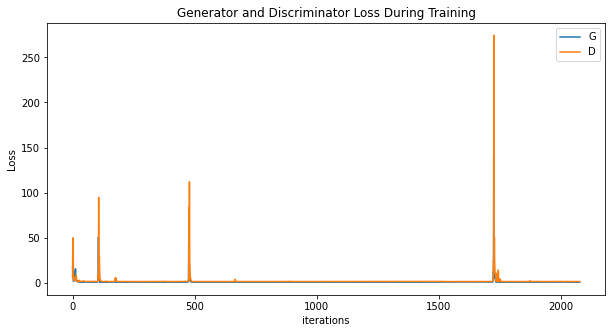

In [14]:
crnngan_curriculum_both_complex.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

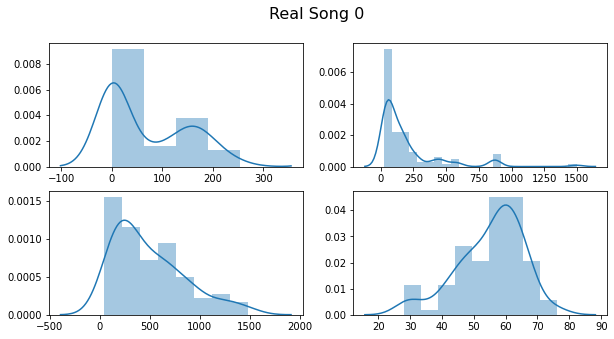

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


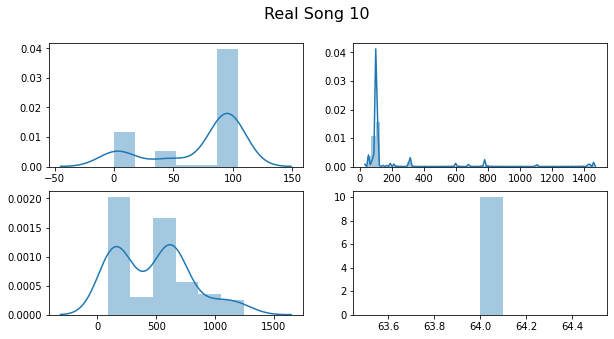

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

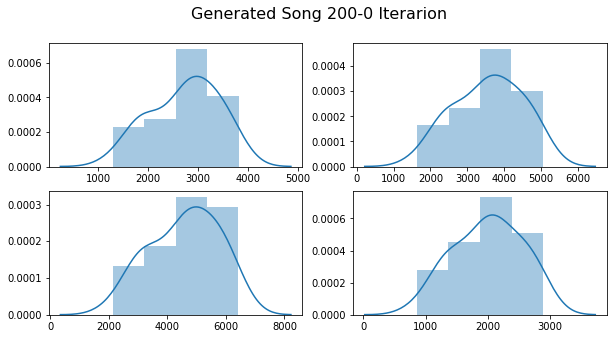

In [18]:
gen_song_both_complex_200_0 = crnngan_curriculum_both_complex.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_0[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_0[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_0[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_0[:,3], ax=axs[1, 1])

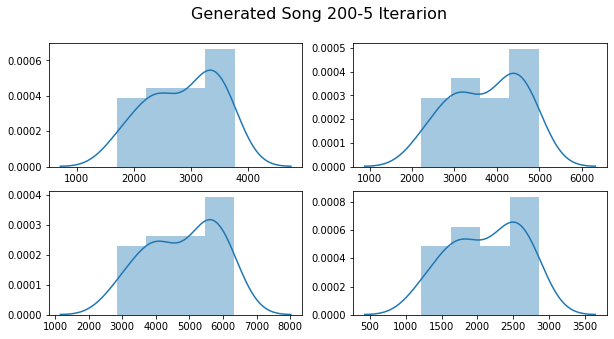

In [19]:
gen_song_both_complex_200_5 = crnngan_curriculum_both_complex.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_5[:,3], ax=axs[1, 1])

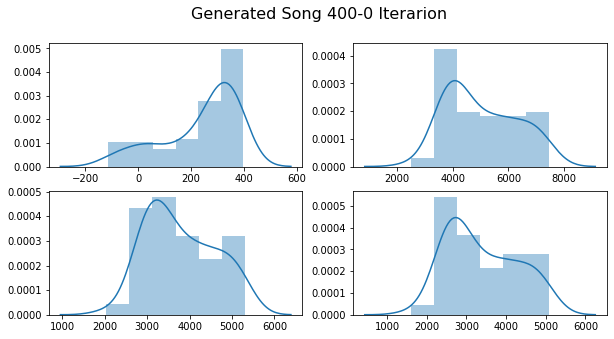

In [20]:
gen_song_both_complex_400_0 = crnngan_curriculum_both_complex.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_0[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_0[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_0[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_0[:,3], ax=axs[1, 1])

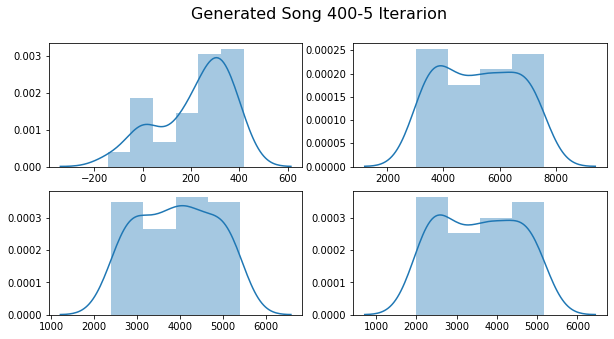

In [21]:
gen_song_both_complex_400_5 = crnngan_curriculum_both_complex.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_5[:,3], ax=axs[1, 1])

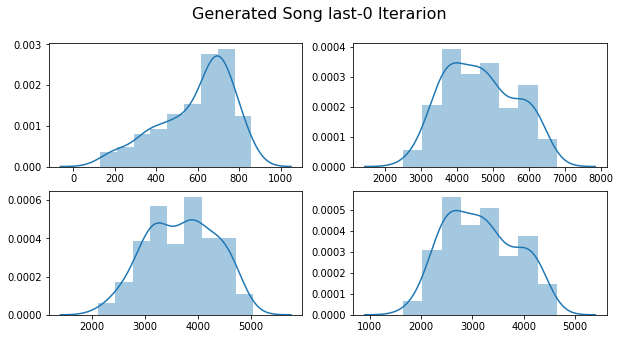

In [22]:
gen_song_both_complex_last = crnngan_curriculum_both_complex.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last[:,3], ax=axs[1, 1])

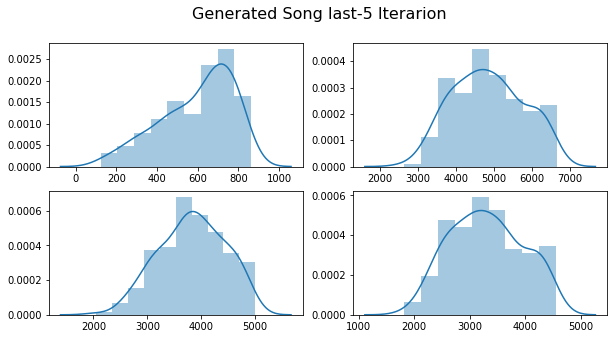

In [23]:
gen_song_both_complex_last_5 = crnngan_curriculum_both_complex.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5[:,3], ax=axs[1, 1])

Too large values...

# Both complex (3 layers deep generator)

In [24]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
complexGenerator = True
G_var_threshold = 1e-3
D_var_threshold = 1e-3
max_sequence_length = 200

crnngan_curriculum_both_complex_deep_gen = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator,
                 max_sequence_length=max_sequence_length, G_var_threshold=G_var_threshold,
                 D_var_threshold=D_var_threshold)

cuda
Complex Generator
Complex Discriminator


In [25]:
crnngan_curriculum_both_complex_deep_gen.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9785	Loss_G: 12.8772	D(x): -2.9719	D(G(z)): -2.9931 / 0.0000
 Time since epoch started: 0.05
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 0.0038	Loss_G: 24.0383	D(x): -0.0038	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 0.46
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 2.5250	Loss_G: 10.3398	D(x): -0.2277	D(G(z)): -0.2301 / -1.4135
 Time since epoch started: 0.87
There are a total of 10 fake songs saved already
Epoch time: 1.06
[1/80][30]	Loss_D: 1.5268	Loss_G: 0.6471	D(x): -0.4780	D(G(z)): -0.4920 / -0.5968
 Time since epoch started: 0.20
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 1.4724	Loss_G: 0.7239	D(x): -0.5271	D(G(z)): -0.5263 / -0.5923
 Time since epoch started: 0.60
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 1.5141	Loss_G: 0.8376	D(x): -0.3968	D(G(z)): -0.4073 / -0.3328
 Time since epoch started: 1.01
There are a total of 25 fa

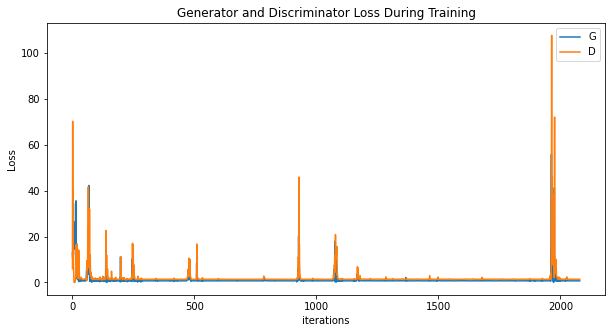

In [26]:
crnngan_curriculum_both_complex_deep_gen.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

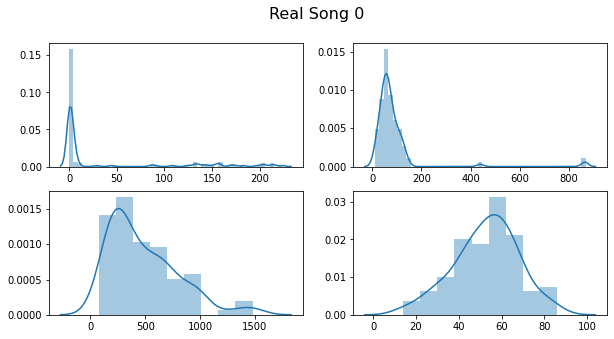

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


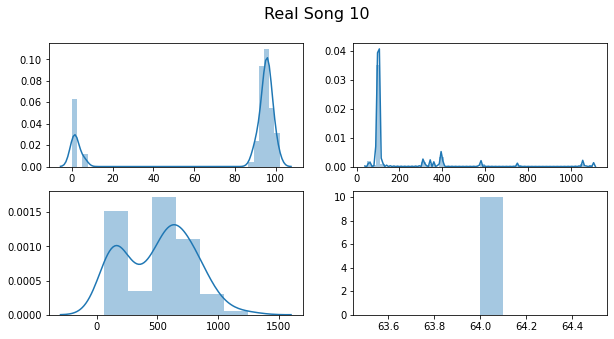

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

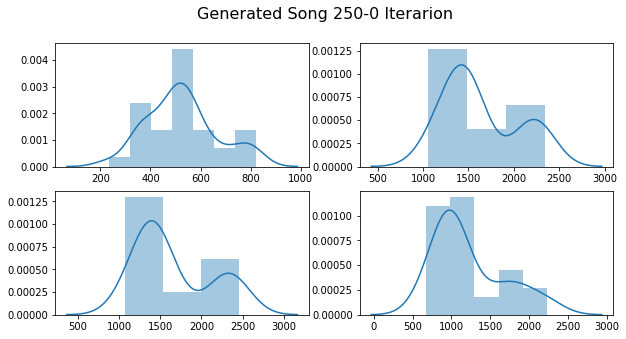

In [30]:
gen_song_both_complex_250_0_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_0_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_0_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_0_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_0_deep_gen[:,3], ax=axs[1, 1])

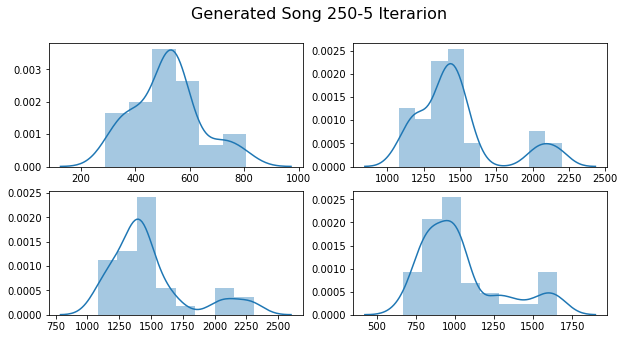

In [31]:
gen_song_both_complex_250_5_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_5_deep_gen[:,3], ax=axs[1, 1])

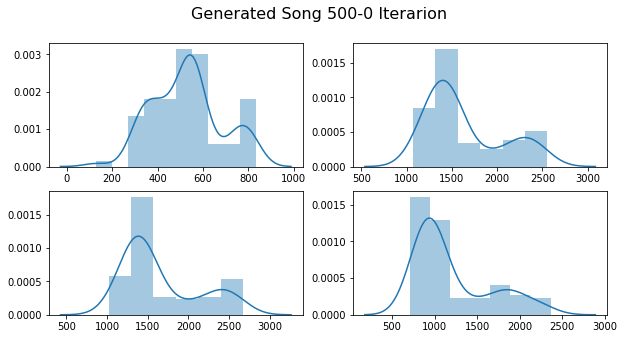

In [32]:
gen_song_both_complex_500_0_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_0_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_0_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_0_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_0_deep_gen[:,3], ax=axs[1, 1])

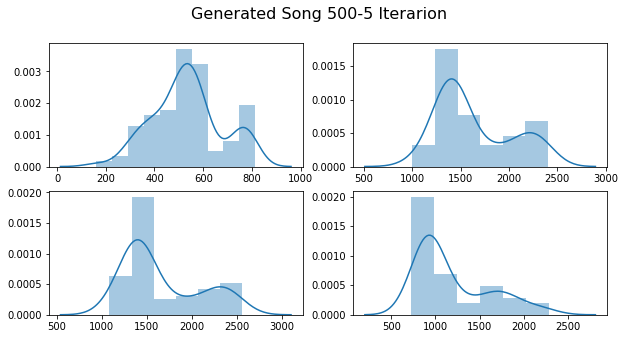

In [33]:
gen_song_both_complex_500_5_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_5_deep_gen[:,3], ax=axs[1, 1])

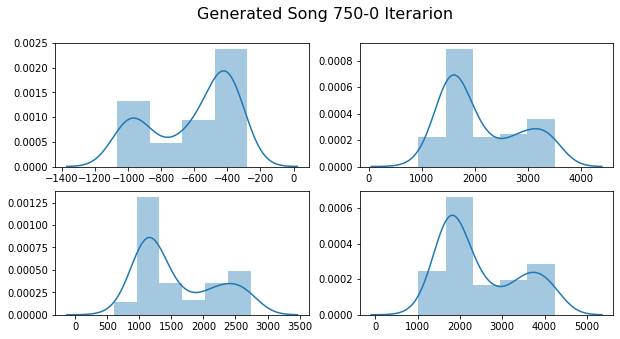

In [34]:
gen_song_both_complex_750_0_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[750][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_0_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_0_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_0_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_0_deep_gen[:,3], ax=axs[1, 1])

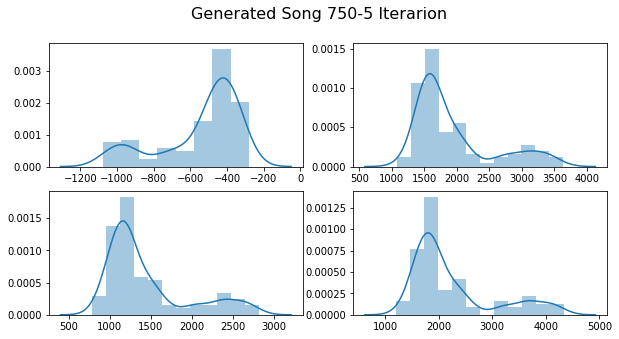

In [35]:
gen_song_both_complex_750_5_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[750][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_5_deep_gen[:,3], ax=axs[1, 1])

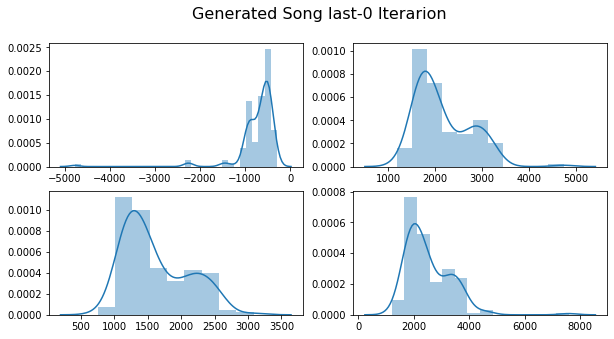

In [36]:
gen_song_both_complex_last_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_deep_gen[:,3], ax=axs[1, 1])

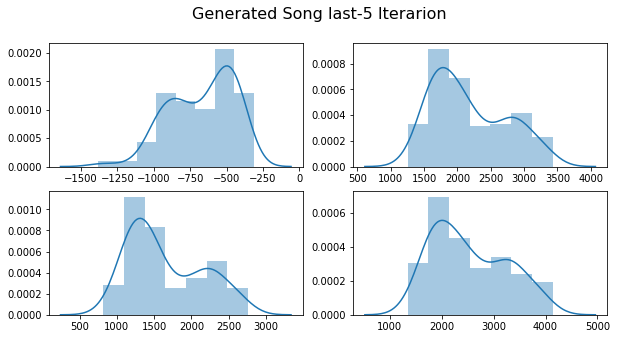

In [37]:
gen_song_both_complex_last_5_deep_gen = crnngan_curriculum_both_complex_deep_gen.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_deep_gen[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_deep_gen[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_deep_gen[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_deep_gen[:,3], ax=axs[1, 1])

Again too large values..

# Both complex (3 layers deep discrminator)

In [66]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
complexGenerator = True
G_var_threshold = 1e-3
D_var_threshold = 1e-3
max_sequence_length = 200

crnngan_curriculum_both_complex_deep_discr = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold,
                 max_sequence_length=max_sequence_length)

cuda
Complex Generator
Complex Discriminator


In [67]:
crnngan_curriculum_both_complex_deep_discr.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9645	Loss_G: 32.6033	D(x): -2.9616	D(G(z)): -2.9939 / 0.0000
 Time since epoch started: 0.05
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 3.0018	Loss_G: 2.3547	D(x): -0.1752	D(G(z)): -0.0677 / -1.6826
 Time since epoch started: 0.45
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 13.1280	Loss_G: 1.5728	D(x): -2.3490	D(G(z)): -2.5500 / -0.6509
 Time since epoch started: 0.85
There are a total of 10 fake songs saved already
Epoch time: 1.05
[1/80][30]	Loss_D: 2.2124	Loss_G: 3.9024	D(x): -1.1996	D(G(z)): -0.9167 / -0.4785
 Time since epoch started: 0.20
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 1.9366	Loss_G: 3.7563	D(x): -0.8070	D(G(z)): -0.5290 / -0.0182
 Time since epoch started: 0.60
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 2.3328	Loss_G: 2.1331	D(x): -0.3852	D(G(z)): -0.3383 / -0.0388
 Time since epoch started: 1.00
There are a total of 25 fak

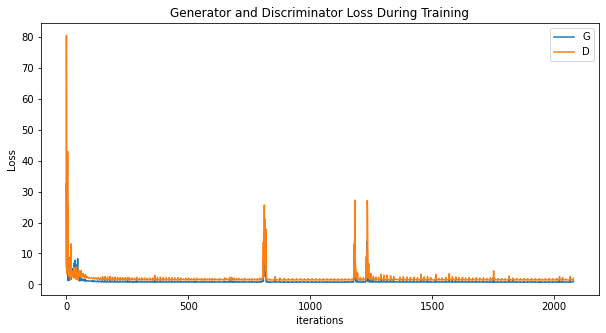

In [68]:
crnngan_curriculum_both_complex_deep_discr.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

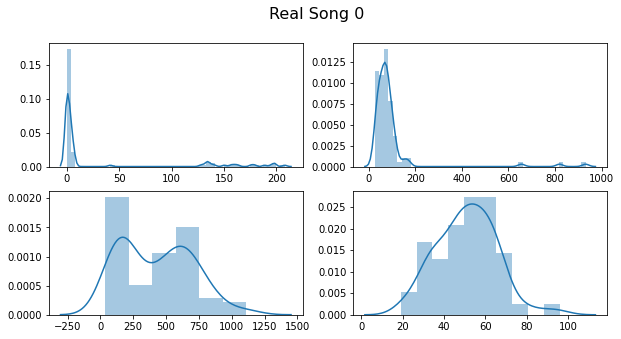

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


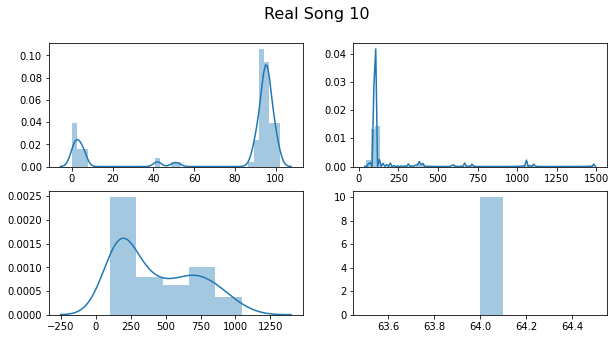

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

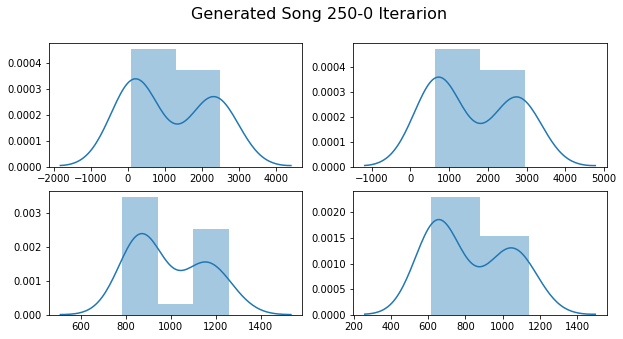

In [72]:
gen_song_both_complex_250_0_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_0_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_0_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_0_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_0_deep_discr[:,3], ax=axs[1, 1])

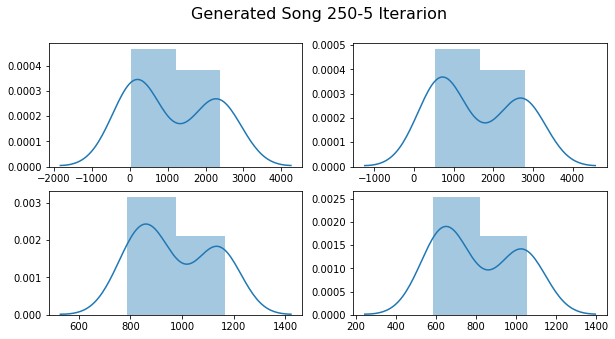

In [73]:
gen_song_both_complex_250_5_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_5_deep_discr[:,3], ax=axs[1, 1])

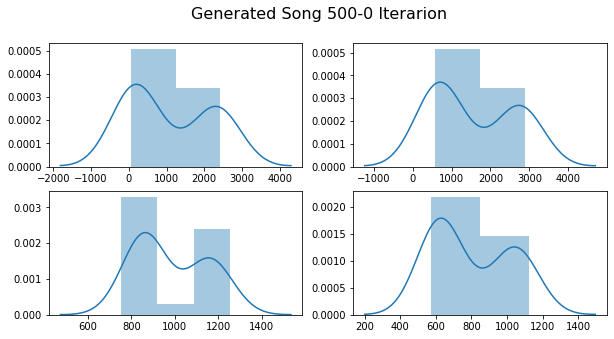

In [74]:
gen_song_both_complex_500_0_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_0_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_0_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_0_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_0_deep_discr[:,3], ax=axs[1, 1])

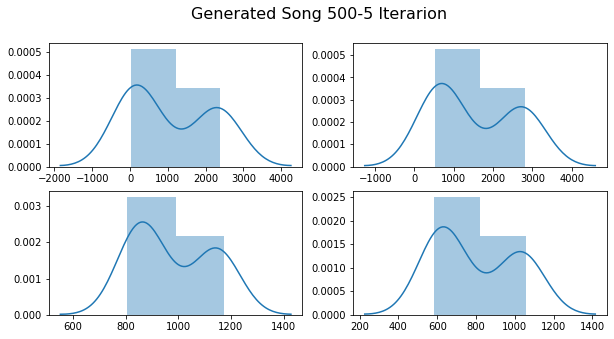

In [75]:
gen_song_both_complex_500_5_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_5_deep_discr[:,3], ax=axs[1, 1])

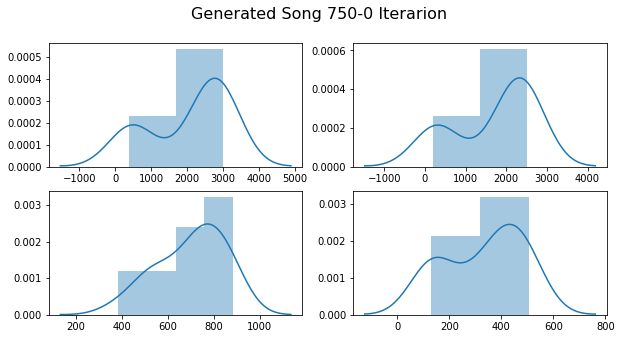

In [76]:
gen_song_both_complex_750_0_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[750][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_0_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_0_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_0_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_0_deep_discr[:,3], ax=axs[1, 1])

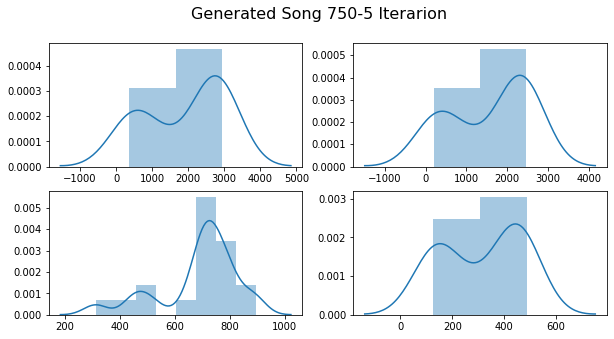

In [77]:
gen_song_both_complex_750_5_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[750][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_5_deep_discr[:,3], ax=axs[1, 1])

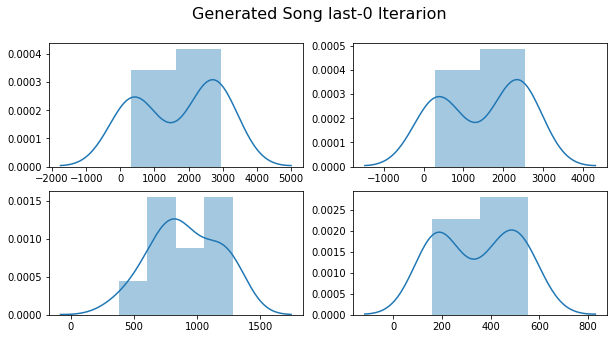

In [78]:
gen_song_both_complex_last_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_deep_discr[:,3], ax=axs[1, 1])

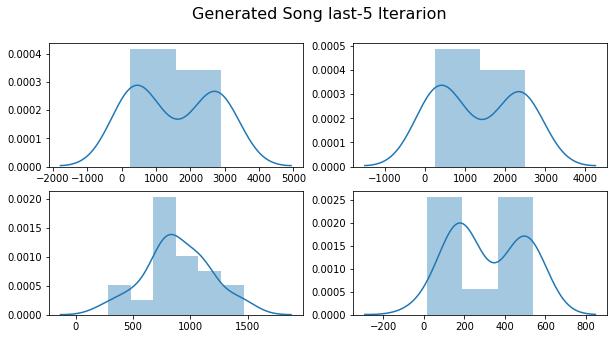

In [79]:
gen_song_both_complex_last_5_deep_discr = crnngan_curriculum_both_complex_deep_discr.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_deep_discr[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_deep_discr[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_deep_discr[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_deep_discr[:,3], ax=axs[1, 1])

Very saturated.

# Both complex (3 layers deep both)

In [80]:
# Data loader
batch_length = 100
sequence_length = 20
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 80
curriculum_learning = True
complexDiscriminator = True
complexGenerator = True
max_sequence_length = 200
G_var_threshold = 1e-3
D_var_threshold = 1e-3

crnngan_curriculum_both_complex_both_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator,
                 G_var_threshold=G_var_threshold, D_var_threshold=D_var_threshold,
                 max_sequence_length=max_sequence_length)

cuda
Complex Generator
Complex Discriminator


In [81]:
crnngan_curriculum_both_complex_both_deep.trainloop(musicDataLoader)

Start training for 80 epochs
[0/80][0]	Loss_D: 5.9889	Loss_G: 23.0592	D(x): -2.9917	D(G(z)): -2.9948 / 0.0000
 Time since epoch started: 0.06
There are a total of 0 fake songs saved already
[0/80][10]	Loss_D: 4.2244	Loss_G: 1.7407	D(x): -0.1775	D(G(z)): -0.1775 / -0.9924
 Time since epoch started: 0.55
There are a total of 5 fake songs saved already
[0/80][20]	Loss_D: 6.1297	Loss_G: 1.8215	D(x): -0.0076	D(G(z)): -0.0076 / -1.4393
 Time since epoch started: 1.02
There are a total of 10 fake songs saved already
Epoch time: 1.26
[1/80][30]	Loss_D: 3.2342	Loss_G: 1.4997	D(x): -0.9770	D(G(z)): -0.9770 / -0.6540
 Time since epoch started: 0.24
There are a total of 15 fake songs saved already
[1/80][40]	Loss_D: 2.4432	Loss_G: 2.3593	D(x): -1.2077	D(G(z)): -1.2077 / -0.0126
 Time since epoch started: 0.72
There are a total of 20 fake songs saved already
[1/80][50]	Loss_D: 10.0723	Loss_G: 1.0034	D(x): -0.8101	D(G(z)): -0.8101 / -0.5799
 Time since epoch started: 1.19
There are a total of 25 fak

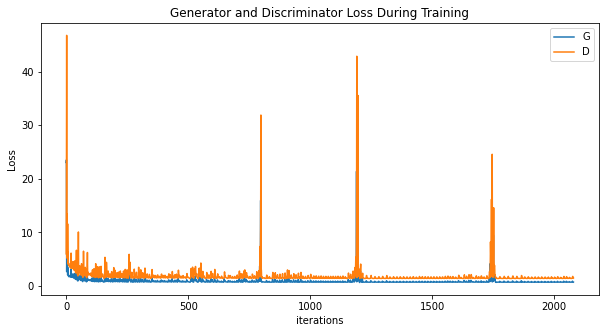

In [82]:
crnngan_curriculum_both_complex_both_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

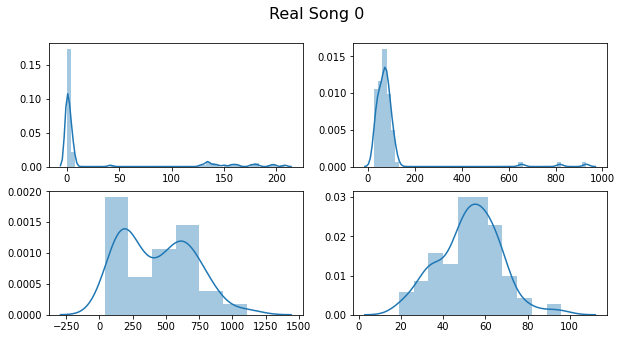

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


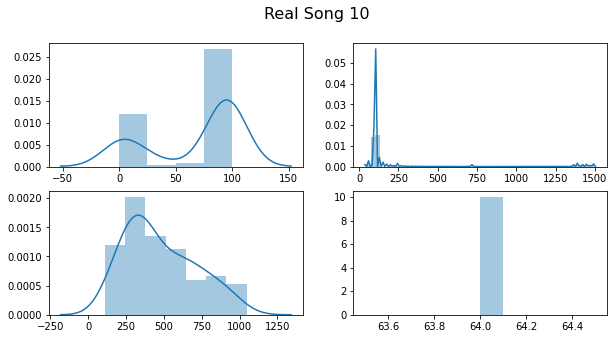

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

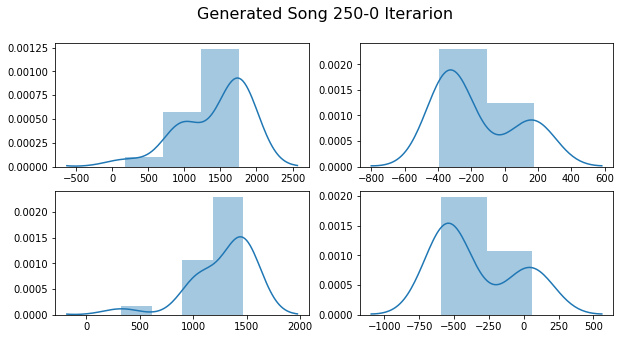

In [86]:
gen_song_both_complex_250_0_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[250][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_0_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_0_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_0_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_0_both_deep[:,3], ax=axs[1, 1])

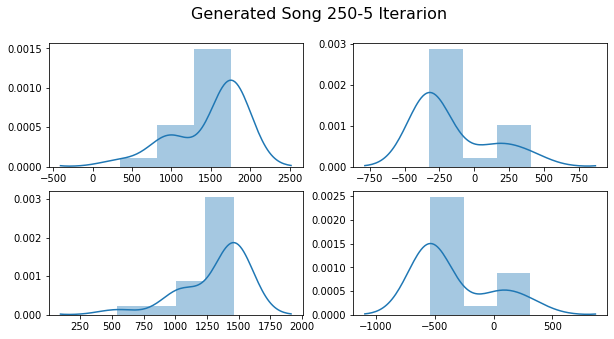

In [87]:
gen_song_both_complex_250_5_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[250][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 250-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_250_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_250_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_250_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_250_5_both_deep[:,3], ax=axs[1, 1])

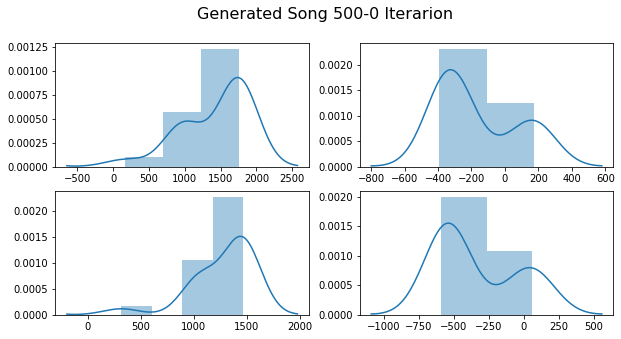

In [88]:
gen_song_both_complex_500_0_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[500][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_0_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_0_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_0_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_0_both_deep[:,3], ax=axs[1, 1])

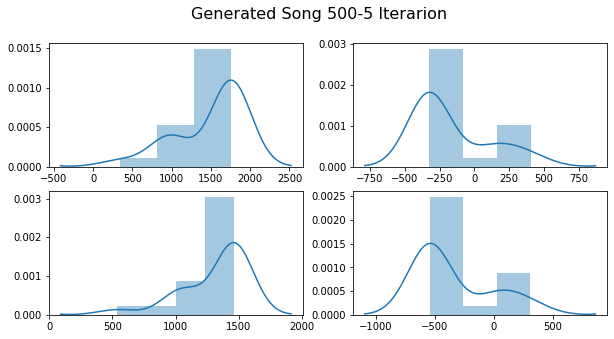

In [89]:
gen_song_both_complex_500_5_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[500][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 500-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_500_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_500_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_500_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_500_5_both_deep[:,3], ax=axs[1, 1])

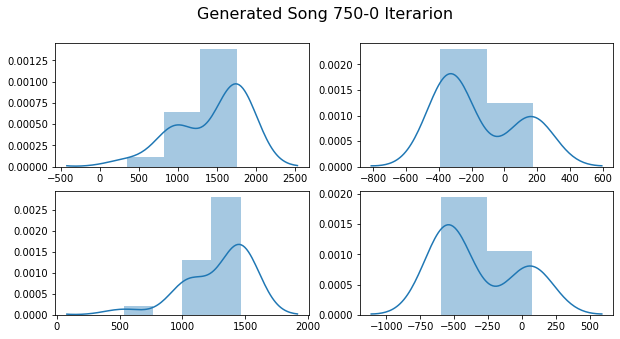

In [90]:
gen_song_both_complex_750_0_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[750][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_0_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_0_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_0_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_0_both_deep[:,3], ax=axs[1, 1])

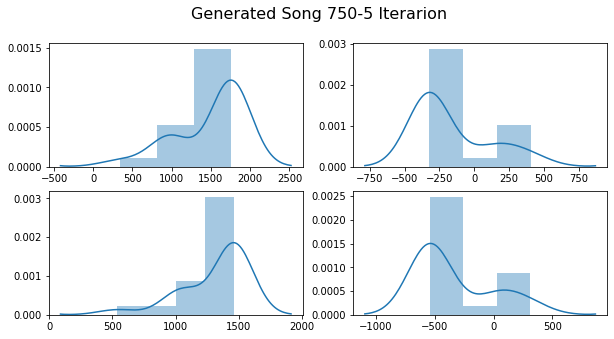

In [91]:
gen_song_both_complex_750_5_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[750][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 750-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_750_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_750_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_750_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_750_5_both_deep[:,3], ax=axs[1, 1])

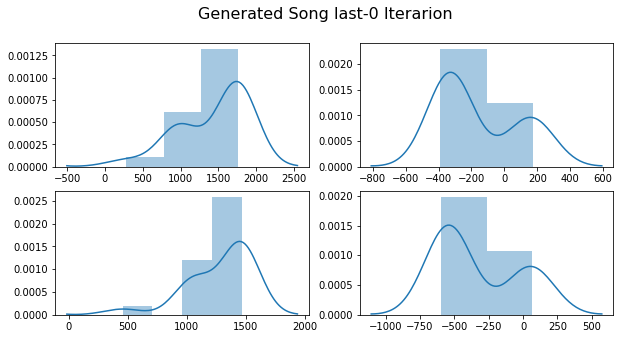

In [92]:
gen_song_both_complex_last_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_both_deep[:,3], ax=axs[1, 1])

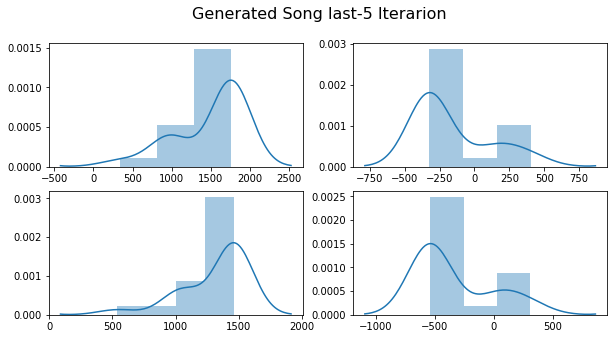

In [93]:
gen_song_both_complex_last_5_both_deep = crnngan_curriculum_both_complex_both_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,3], ax=axs[1, 1])

Doesn't look very good...

Curriculum learning hasn't worked very good specially when used within complex structures... We'll see what happens when we apply normalization.